In [1]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [2]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector])
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [3]:
def get_xhigh(eq_id):
    
    if eq_id == '2023-04-13_M6':
        xhigh = 60
    elif eq_id == '2022-12-20_M6.4':
        if hypdist < 200:
            xhigh = 20
        else:
            xhigh = 40
    elif eq_id == '2022-11-22_M6.2': # Weird one that pauses for a while then grows again
        xhigh = 25
    elif eq_id == '2021-12-20_M6.2':
        if hypdist < 30: 
            xhigh = 20
        elif 30 < hypdist < 50:
            xhigh = 25
        elif 50 < hypdist < 100:
            xhigh = 30
        else:
            xhigh = 60
    elif eq_id == '2021-07-08_M6': # Lots of more gradual ones with pause again
        if hypdist < 300:
            xhigh = 25
        else:
            xhigh = 50
    elif eq_id == '2020-05-15_M6.5':
        xhigh = 30
    elif eq_id == '2020-03-31_M6.5':
        xhigh = 35
    elif eq_id == '2019-12-25_M6.3':
        xhigh = 35
    elif eq_id == '2019-12-23T20_M6':
        xhigh = 60
    elif eq_id == '2019-12-23T19_M6':
        xhigh = 60
    elif eq_id == '2019-08-29_M6.3': # All flatten fast
        xhigh = 60
    elif eq_id == '2019-07-06_M7.1': # Ridgecrest mainshock
        xhigh = 27
    elif eq_id == '2019-07-04_M6.4': # Ridgecrest foreshock
        if hypdist < 50:
            xhigh = 20
        else:
            xhigh = 27
    elif eq_id == '2019-07-04_M6.2':
        xhigh = 35
    # elif eq_id == '2018-10-22T06_M6.5': # No waveforms with high enough SNR
    #     xhigh = 
    elif eq_id == '2018-10-22_M6.8': # Has like 3 slopes? Letting it go long
        xhigh = 60
    elif eq_id == '2018-10-22T05_M6.5': # Somewhat of a pause but all similar? Going long
        xhigh = 60
    elif eq_id == '2018-08-22_M6.2':
        xhigh = 60
    elif eq_id == '2016-12-08_M6.6':
        xhigh = 60
    elif eq_id == '2014-08-24_M6.02':
        xhigh = 27
    elif eq_id == '2014-04-24_M6.5':
        xhigh = 50
    elif eq_id == '2014-03-10_M6.8':
        if hypdist < 110:
            xhigh = 25
        else:
            xhigh = 40
    elif eq_id == '2013-09-04_M6':
        xhigh = 25
    elif eq_id == '2013-09-03_M6.1':
        xhigh = 30
    elif eq_id == '2012-12-14_M6.3':
        xhigh = 25
    elif eq_id == '2012-11-08_M6.1':
        xhigh = 42
    elif eq_id == '2012-04-11_M6':
        xhigh = 30
    elif eq_id == '2011-09-09_M6.4':
        xhigh = 35
    elif eq_id == '2010-04-04_M7.2':
        xhigh = 35
    elif eq_id == '2010-01-10_M6.5':
        xhigh = 35
    elif eq_id == '2008-01-10_M6.3':
        xhigh = 24
    else:
        xhigh = 'no data'
    
    return xhigh

In [4]:
# Events

path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

In [5]:
# earthquakes

In [6]:
weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes.iloc[[11,12,13]]
    
one_at_a_time = False
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

# Stations

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_3COMP_newdetrend.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

In [7]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

counter = 0

for idx in range(len(dist_array)):
    
    eq_id = dist_array[idx,0]
    mag = dist_array[idx,4]
    sta = dist_array[idx,5]

    # print(eq_id, sta)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)

    xlow = 10
    xhigh = get_xhigh(eq_id)
        
    try:

        hypdist = float(dist_array[idx,8])
        int_hypdist = int(hypdist)
        snr = float(dist_array[idx,9])
        int_snr = int(snr) # Breaks try condition if snr is nan
        
        # Read in data - peak strain data only has the ones with SNR > 2
        pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + str(eq_id) + '/' + str(sta) + '.mseed')
        counter += 1
        # print(counter)
        # pst.plot()
        # plt.plot(pst[0].times(), pst[0].data)
        # plt.semilogy()

        print('Processing ' + str(eq_id) + ', ' + str(sta))

    except:
        continue # skips to next station

    print('Processing ' + str(sta))
        
    times = pst[0].times()
    data = pst[0].data
    log10_data = np.log10(data)
    samp_rate = pst[0].stats.sampling_rate
    print(samp_rate)

    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)

    # Split into x and y vectors
    xobserved = times[vec_start:vec_end]
    yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]

    # in order to pass the x variable into the target function it needs to be 
    # converted to a Theano "shared" variable
    pt_xobserved = pytensor.shared(xobserved)
    pt_x0 = pytensor.shared(x0)
    pt_y0 = pytensor.shared(y0)

    # MCMC run parameters, these are good numbers for a "production" run. If you are
    # fooling arund these can be lower to iterate faster
    Nburn = 5000 # burn in samples that get discarded
    Nmcmc = 15000 # bump to at least 5-10k
    Nchains = 4
    Ncores = 1

    # Bounds for the prior distributions
    m1_low = -1; m1_high = 5
    m2_low = -1; m2_high = 1
    xinter_low = 10 ; xinter_high = 25 # location of the line slope change

    # Define the Bayesian model
    with pm.Model()as model:

        # Use normal distributions as priors
        # m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
        # m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
        m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high)
        m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
        xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
        sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)

        # This is the model
        likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                observed = yobserved, sigma = sigma)

        # NUTS sampler (default) is gradient based and won't work, use metropolis
        step = pm.Metropolis(scaling = 0.1)

        # This runs the mcmc sampler
        mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)

    # Done, now is post-processing to get the data out of the sampler

    posterior = az.extract(mcmc)

    # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
    m1_array = posterior.m1.values
    m1 = np.mean(m1_array)
    # print('m1 mean: ' + str(round(m1,2)))

    m2_array = posterior.m2.values
    m2 = np.mean(m2_array)
    # print('m2 mean: ' + str(round(m2,2)))

    xinter_array = posterior.xinter.values
    xinter = np.mean(xinter_array)
    # print('xinter Mean: ' + str(round(xinter,2)))

    sigma_array = posterior.sigma.values
    sigma = np.mean(sigma_array)

    # Lines!
    b1 = y0 - m1*x0
    b2 = m1*xinter + b1 - m2*xinter

    # Make plot to check stuff
    xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
    ypredicted = m1*xpredicted + b1
    i = np.where(xpredicted > xinter)[0]
    ypredicted[i] = m2*xpredicted[i] + b2

    # Get one-sigma region (need to obtain a ton of forward models and get stats)
    N = len(posterior.m1.values)

    yfit = np.zeros((len(xpredicted), N))
    for k in range(N):
        yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
    mu = yfit.mean(1)
    sig = yfit.std(1) * 1.95 #for 95% confidence
    mu_plus = mu + sig
    mu_minus = mu - sig

    # Least squares
    mls, bls = np.polyfit(xobserved, yobserved, 1)

    # Find the transition point in ypredicted
    diff = np.round(np.diff(ypredicted), decimals = 5)
    # print(diff)
    first_slope = diff[0]
    second_slope = diff[-1]
    trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1

    # Get the transition point
    mcmc_trans_x = xpredicted[trans_idx] # Number
    mcmc_trans_y = ypredicted[trans_idx]

    # Append things
    events_list.append(eq_id)
    mags_list.append(mag)
    stas_list.append(sta)
    hypdist_list.append(int_hypdist)
    xhighs_list.append(xhigh)
    m1s_list.append(m1)
    m2s_list.append(m2)
    xinters_list.append(xinter)
    sigmas_list.append(sigma)
    trans_time_list.append(mcmc_trans_x)

    # Create folder for the event
    array_save_dir = path_to_files + '3comp_newdetrend_mcmc_arrays/' + str(eq_id) + '/' + str(sta) + '/'
    if os.path.isdir(array_save_dir):
        pass
    else:
        os.makedirs(array_save_dir)

    np.save(array_save_dir + 'xobserved.npy', xobserved)
    np.save(array_save_dir + 'yobserved.npy', yobserved)
    np.save(array_save_dir + 'xpredicted.npy', xpredicted)
    np.save(array_save_dir + 'ypredicted.npy', ypredicted)
    np.save(array_save_dir + 'forward_mus.npy', mu)
    np.save(array_save_dir + 'foward_sigs.npy', sig)

    summary = az.summary(mcmc, fmt = 'wide')
    print(summary)
    summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)

    # Folder for figures
    fig_save_dir = path_to_files + 'figures/3comp_newdetrend_mcmc_plots/' + str(eq_id) + '/'
    if os.path.isdir(fig_save_dir):
        pass
    else:
        os.makedirs(fig_save_dir)

    az.plot_trace(mcmc)
    # plt.show()
    plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
    plt.close()

    # Plot all solutions
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111)
    ax.set_title(str(sta))

    ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
    ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
    # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
    # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
    ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
    # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
    # ax2 = ax.twinx()
    # ax2.plot(xobserved, pythags_arr, color = 'violet')
    # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
    ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
    ax.set_xlabel('Time (s) - p-wave at 10s')
    ax.set_ylabel('log10 of peak strain')
    # ax.set_xlim(10,13)
    ax.legend()

    # plt.show()

    plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
    plt.close()

Processing 2023-04-13_M6, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 170 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.936  0.125   0.754    1.161      0.060    0.046       5.0   
m2       0.014  0.000   0.013    0.014      0.000    0.000       9.0   
xinter  11.617  0.213  11.243   11.939      0.102    0.078       5.0   
sigma    0.086  0.003   0.080    0.093      0.001    0.001       7.0   

        ess_tail  r_hat  
m1          22.0   2.55  
m2          25.0   1.40  
xinter      24.0   2.52  
sigma       33.0   1.58  
Processing 2023-04-13_M6, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 179 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.714  0.109   0.552    0.915      0.053    0.041       5.0   
m2       0.014  0.000   0.014    0.015      0.000    0.000       6.0   
xinter  11.545  0.228  11.137   11.933      0.110    0.084       5.0   
sigma    0.066  0.002   0.062    0.071      0.001    0.001       7.0   

        ess_tail  r_hat  
m1          19.0   2.84  
m2          28.0   1.68  
xinter      21.0   2.84  
sigma       27.0   1.53  
Processing 2023-04-13_M6, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.638  0.516   1.071    2.634      0.254    0.195       5.0   
m2       0.017  0.000   0.016    0.017      0.000    0.000       9.0   
xinter  11.009  0.272  10.561   11.411      0.131    0.099       5.0   
sigma    0.080  0.009   0.066    0.097      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          12.0   2.61  
m2          39.0   1.41  
xinter      12.0   2.60  
sigma       27.0   2.28  
Processing 2023-04-13_M6, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.142  0.659   1.366    3.432      0.323    0.248       5.0   
m2       0.010  0.000   0.009    0.010      0.000    0.000       6.0   
xinter  10.989  0.275  10.560   11.427      0.130    0.099       5.0   
sigma    0.082  0.016   0.059    0.111      0.007    0.006       5.0   

        ess_tail  r_hat  
m1          16.0   2.65  
m2          18.0   1.87  
xinter      16.0   2.66  
sigma       24.0   2.39  
Processing 2023-04-13_M6, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.053  0.071   0.929    1.170      0.034    0.026       5.0   
m2       0.013  0.000   0.013    0.013      0.000    0.000      10.0   
xinter  11.506  0.108  11.338   11.701      0.051    0.039       5.0   
sigma    0.063  0.002   0.059    0.068      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          20.0   2.92  
m2          55.0   1.34  
xinter      18.0   2.91  
sigma       25.0   1.43  
Processing 2022-12-20_M6.4, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.554  0.007   0.543    0.567      0.002    0.001      18.0   
m2       0.029  0.000   0.029    0.030      0.000    0.000      29.0   
xinter  12.868  0.041  12.789   12.937      0.011    0.008      14.0   
sigma    0.076  0.002   0.072    0.080      0.000    0.000   12580.0   

        ess_tail  r_hat  
m1          39.0   1.18  
m2          45.0   1.10  
xinter      36.0   1.23  
sigma    13400.0   1.00  
Processing 2022-12-20_M6.4, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 169 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.858  0.020   0.826    0.893      0.008    0.006       6.0   
m2       0.027  0.000   0.027    0.028      0.000    0.000      30.0   
xinter  12.312  0.062  12.209   12.417      0.024    0.018       7.0   
sigma    0.086  0.003   0.082    0.091      0.000    0.000    3129.0   

        ess_tail  r_hat  
m1          16.0   1.66  
m2         119.0   1.10  
xinter      15.0   1.62  
sigma     7006.0   1.00  
Processing 2022-12-20_M6.4, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 161 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.909  0.020   0.875    0.942      0.007    0.005      10.0   
m2       0.030  0.001   0.029    0.031      0.000    0.000     125.0   
xinter  12.444  0.058  12.339   12.538      0.018    0.013      12.0   
sigma    0.113  0.003   0.107    0.119      0.000    0.000   11587.0   

        ess_tail  r_hat  
m1          23.0   1.32  
m2         191.0   1.04  
xinter      22.0   1.26  
sigma    12755.0   1.00  
Processing 2022-12-20_M6.4, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 167 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.734  0.013   0.705    0.754      0.005    0.003       9.0   
m2       0.035  0.001   0.034    0.036      0.000    0.000      51.0   
xinter  12.827  0.060  12.730   12.954      0.020    0.015       9.0   
sigma    0.115  0.003   0.109    0.121      0.000    0.000   12243.0   

        ess_tail  r_hat  
m1          47.0   1.38  
m2         158.0   1.09  
xinter      48.0   1.38  
sigma    13126.0   1.00  
Processing 2022-12-20_M6.4, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 160 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.090  0.048   0.986    1.152      0.020    0.015       6.0   
m2       0.032  0.001   0.030    0.033      0.000    0.000      12.0   
xinter  11.962  0.101  11.825   12.162      0.041    0.030       6.0   
sigma    0.096  0.003   0.090    0.102      0.001    0.000      43.0   

        ess_tail  r_hat  
m1          24.0   1.70  
m2         121.0   1.27  
xinter      27.0   1.73  
sigma       77.0   1.06  
Processing 2022-12-20_M6.4, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.623  0.474   2.863    4.558      0.222    0.170       5.0   
m2       0.029  0.001   0.027    0.030      0.000    0.000       9.0   
xinter  10.812  0.112  10.624   11.012      0.051    0.038       5.0   
sigma    0.129  0.007   0.117    0.144      0.002    0.002       9.0   

        ess_tail  r_hat  
m1          27.0   2.33  
m2          44.0   1.38  
xinter      27.0   2.34  
sigma       43.0   1.36  
Processing 2022-12-20_M6.4, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 173 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.429  0.258   1.945    2.799      0.119    0.091       5.0   
m2       0.023  0.001   0.021    0.024      0.000    0.000       9.0   
xinter  11.075  0.128  10.902   11.318      0.058    0.043       5.0   
sigma    0.122  0.007   0.112    0.138      0.003    0.002       8.0   

        ess_tail  r_hat  
m1          22.0   2.39  
m2          50.0   1.37  
xinter      21.0   2.40  
sigma       43.0   1.40  
Processing 2022-12-20_M6.4, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.656  0.061   1.530    1.758      0.025    0.018       6.0   
m2       0.048  0.001   0.047    0.049      0.000    0.000      72.0   
xinter  11.636  0.068  11.519   11.777      0.027    0.020       6.0   
sigma    0.142  0.004   0.134    0.150      0.000    0.000     498.0   

        ess_tail  r_hat  
m1          28.0   1.85  
m2          63.0   1.05  
xinter      30.0   1.82  
sigma     1520.0   1.01  
Processing 2022-12-20_M6.4, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 161 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.824  0.286   2.346    3.342      0.098    0.071       9.0   
m2       0.058  0.007   0.045    0.070      0.002    0.001      17.0   
xinter  10.826  0.096  10.664   10.987      0.034    0.025       8.0   
sigma    0.197  0.010   0.179    0.216      0.000    0.000   11750.0   

        ess_tail  r_hat  
m1          22.0   1.42  
m2          70.0   1.16  
xinter      20.0   1.42  
sigma    15067.0   1.00  
Processing 2022-12-20_M6.4, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.116  0.722   2.869    4.999      0.331    0.253       5.0   
m2       0.012  0.001   0.010    0.014      0.000    0.000       7.0   
xinter  10.766  0.158  10.600   11.073      0.069    0.052       5.0   
sigma    0.160  0.014   0.140    0.189      0.006    0.004       6.0   

        ess_tail  r_hat  
m1          26.0   2.28  
m2          50.0   1.51  
xinter      26.0   2.27  
sigma       31.0   1.69  
Processing 2022-12-20_M6.4, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.558  0.015   0.532    0.586      0.002    0.002      44.0   
m2       0.060  0.003   0.053    0.066      0.000    0.000     146.0   
xinter  12.121  0.084  11.961   12.266      0.012    0.009      49.0   
sigma    0.082  0.004   0.075    0.090      0.000    0.000   11675.0   

        ess_tail  r_hat  
m1          66.0   1.08  
m2         380.0   1.02  
xinter      53.0   1.07  
sigma    13847.0   1.00  
Processing 2022-12-20_M6.4, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.713  0.011   0.692    0.734      0.004    0.003       8.0   
m2       0.030  0.001   0.029    0.031      0.000    0.000     162.0   
xinter  12.620  0.046  12.532   12.698      0.016    0.012       9.0   
sigma    0.107  0.003   0.101    0.112      0.000    0.000   12459.0   

        ess_tail  r_hat  
m1          16.0   1.44  
m2         191.0   1.03  
xinter      18.0   1.42  
sigma    12882.0   1.00  
Processing 2022-12-20_M6.4, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.431  0.005   0.422    0.440      0.001    0.001      23.0   
m2       0.033  0.000   0.032    0.033      0.000    0.000     100.0   
xinter  13.017  0.044  12.931   13.102      0.010    0.007      20.0   
sigma    0.071  0.002   0.067    0.075      0.000    0.000   12116.0   

        ess_tail  r_hat  
m1          58.0   1.12  
m2         175.0   1.03  
xinter      36.0   1.14  
sigma    13223.0   1.00  
Processing 2022-12-20_M6.4, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.957  0.040   4.880    5.000      0.004    0.003     118.0   
m2       0.150  0.004   0.142    0.157      0.000    0.000     378.0   
xinter  10.477  0.006  10.466   10.489      0.000    0.000     179.0   
sigma    0.150  0.008   0.136    0.165      0.000    0.000   11045.0   

        ess_tail  r_hat  
m1         251.0   1.02  
m2         755.0   1.01  
xinter     286.0   1.01  
sigma    12653.0   1.00  
Processing 2022-12-20_M6.4, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.457  0.263   1.857    2.871      0.054    0.039      26.0   
m2       0.123  0.004   0.116    0.130      0.000    0.000     115.0   
xinter  10.508  0.072  10.399   10.642      0.015    0.011      25.0   
sigma    0.133  0.007   0.121    0.146      0.000    0.000    2672.0   

        ess_tail  r_hat  
m1          50.0   1.14  
m2         338.0   1.03  
xinter      49.0   1.14  
sigma     3610.0   1.00  
Processing 2022-11-22_M6.2, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.748  1.134   0.089    3.256      0.510    0.385       6.0   
m2       0.040  0.008   0.024    0.047      0.004    0.003       7.0   
xinter  11.757  2.845  10.049   16.818      1.421    1.089       6.0   
sigma    0.069  0.010   0.058    0.089      0.005    0.004       7.0   

        ess_tail  r_hat  
m1          50.0   1.75  
m2          44.0   1.54  
xinter      37.0   1.74  
sigma       27.0   1.53  
Processing 2022-11-22_M6.2, B084
Processing B084
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.870  0.258   4.313    5.000      0.055    0.040      17.0   
m2       0.018  0.002   0.015    0.021      0.000    0.000      84.0   
xinter  10.302  0.021  10.287   10.342      0.004    0.003      24.0   
sigma    0.104  0.005   0.095    0.113      0.000    0.000     147.0   

        ess_tail  r_hat  
m1          41.0   1.17  
m2         194.0   1.04  
xinter      41.0   1.11  
sigma      129.0   1.02  
Processing 2022-11-22_M6.2, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.697  0.018   0.665    0.730      0.003    0.002      41.0   
m2       0.062  0.002   0.057    0.066      0.000    0.000     156.0   
xinter  12.331  0.078  12.176   12.468      0.012    0.009      41.0   
sigma    0.126  0.005   0.116    0.135      0.000    0.000   12068.0   

        ess_tail  r_hat  
m1          81.0   1.04  
m2         413.0   1.02  
xinter      81.0   1.04  
sigma    14427.0   1.00  
Processing 2022-11-22_M6.2, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.044  0.016   1.013    1.071      0.003    0.002      28.0   
m2       0.051  0.002   0.046    0.055      0.000    0.000     235.0   
xinter  12.400  0.045  12.324   12.498      0.009    0.006      27.0   
sigma    0.132  0.005   0.121    0.142      0.000    0.000   12820.0   

        ess_tail  r_hat  
m1          95.0   1.13  
m2         481.0   1.03  
xinter     121.0   1.13  
sigma    15205.0   1.00  
Processing 2022-11-22_M6.2, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.431  0.008   0.415    0.444      0.001    0.001     103.0   
m2       0.070  0.003   0.066    0.075      0.000    0.000     327.0   
xinter  13.491  0.093  13.318   13.663      0.009    0.007     102.0   
sigma    0.125  0.005   0.116    0.135      0.000    0.000   13838.0   

        ess_tail  r_hat  
m1         156.0   1.02  
m2         543.0   1.01  
xinter     173.0   1.02  
sigma    15367.0   1.00  
Processing 2022-11-22_M6.2, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.533  0.006   0.521    0.544      0.001    0.000      90.0   
m2       0.081  0.002   0.077    0.085      0.000    0.000     295.0   
xinter  13.481  0.057  13.366   13.581      0.006    0.004      80.0   
sigma    0.102  0.004   0.094    0.110      0.000    0.000   13082.0   

        ess_tail  r_hat  
m1         206.0   1.08  
m2         419.0   1.03  
xinter     136.0   1.07  
sigma    14521.0   1.00  
Processing 2021-12-20_M6.2, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.608  0.089   0.498    0.767      0.044    0.033       4.0   
m2       0.012  0.001   0.011    0.014      0.000    0.000       5.0   
xinter  13.191  0.487  12.396   13.869      0.240    0.184       4.0   
sigma    0.143  0.003   0.137    0.149      0.000    0.000      90.0   

        ess_tail  r_hat  
m1          16.0   3.22  
m2          30.0   2.07  
xinter      17.0   3.20  
sigma     9228.0   1.03  
Processing 2021-12-20_M6.2, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.175  0.007   0.171    0.181      0.001    0.001      21.0   
m2       0.006  0.001   0.005    0.007      0.000    0.000      61.0   
xinter  21.557  0.463  21.092   21.893      0.078    0.056      30.0   
sigma    0.139  0.008   0.130    0.145      0.001    0.001     158.0   

        ess_tail  r_hat  
m1          39.0   1.13  
m2         101.0   1.05  
xinter      38.0   1.10  
sigma       63.0   1.02  
Processing 2021-12-20_M6.2, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.664  0.062   0.553    0.786      0.026    0.020       6.0   
m2       0.027  0.001   0.025    0.028      0.000    0.000      14.0   
xinter  13.239  0.356  12.644   13.953      0.152    0.114       6.0   
sigma    0.283  0.006   0.270    0.294      0.000    0.000    9577.0   

        ess_tail  r_hat  
m1          11.0   1.83  
m2          46.0   1.20  
xinter      11.0   1.82  
sigma    11102.0   1.00  
Processing 2021-12-20_M6.2, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.220  0.024   0.208    0.270      0.006    0.004      15.0   
m2       0.006  0.002   0.004    0.012      0.001    0.000      24.0   
xinter  20.750  1.084  17.953   21.370      0.286    0.208      19.0   
sigma    0.189  0.016   0.174    0.228      0.004    0.003      39.0   

        ess_tail  r_hat  
m1          25.0   1.18  
m2          25.0   1.11  
xinter      24.0   1.15  
sigma       24.0   1.07  
Processing 2021-12-20_M6.2, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.967  0.803   1.968    4.531      0.392    0.301       5.0   
m2       0.029  0.001   0.028    0.030      0.000    0.000       8.0   
xinter  10.934  0.236  10.565   11.323      0.110    0.084       5.0   
sigma    0.131  0.015   0.109    0.160      0.006    0.005       5.0   

        ess_tail  r_hat  
m1          11.0   2.49  
m2          34.0   1.46  
xinter      11.0   2.49  
sigma       26.0   2.24  
Processing 2021-12-20_M6.2, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.083  0.634   1.184    3.250      0.303    0.231       5.0   
m2       0.025  0.001   0.024    0.026      0.000    0.000      10.0   
xinter  11.208  0.359  10.655   11.818      0.166    0.125       5.0   
sigma    0.184  0.010   0.168    0.204      0.004    0.003       6.0   

        ess_tail  r_hat  
m1          14.0   2.48  
m2          34.0   1.32  
xinter      15.0   2.47  
sigma       29.0   1.70  
Processing 2021-12-20_M6.2, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.438  0.050   0.383    0.542      0.023    0.017       5.0   
m2       0.005  0.001   0.003    0.006      0.000    0.000       6.0   
xinter  14.027  0.456  13.104   14.605      0.209    0.158       5.0   
sigma    0.176  0.004   0.168    0.184      0.001    0.000      61.0   

        ess_tail  r_hat  
m1          17.0   2.05  
m2          21.0   1.88  
xinter      16.0   2.14  
sigma      135.0   1.04  
Processing 2021-12-20_M6.2, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.845  0.024   1.800    1.888      0.005    0.003      27.0   
m2      -0.000  0.002  -0.004    0.004      0.000    0.000     325.0   
xinter  11.242  0.017  11.212   11.278      0.003    0.002      29.0   
sigma    0.080  0.004   0.072    0.088      0.000    0.000    9899.0   

        ess_tail  r_hat  
m1          58.0   1.12  
m2         479.0   1.01  
xinter      38.0   1.12  
sigma    13479.0   1.00  
Processing 2021-12-20_M6.2, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.912  0.378   1.404    2.638      0.184    0.141       5.0   
m2       0.014  0.000   0.013    0.014      0.000    0.000       8.0   
xinter  11.180  0.229  10.813   11.559      0.108    0.082       5.0   
sigma    0.100  0.010   0.086    0.120      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          16.0   2.52  
m2          51.0   1.43  
xinter      17.0   2.51  
sigma       27.0   2.20  
Processing 2021-12-20_M6.2, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.366  0.212   0.925    1.692      0.098    0.074       5.0   
m2       0.017  0.001   0.015    0.018      0.000    0.000      18.0   
xinter  11.577  0.305  11.209   12.285      0.136    0.102       5.0   
sigma    0.214  0.006   0.204    0.227      0.002    0.001      15.0   

        ess_tail  r_hat  
m1          21.0   2.38  
m2          32.0   1.15  
xinter      21.0   2.38  
sigma       26.0   1.18  
Processing 2021-12-20_M6.2, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.331  0.082   0.204    0.453      0.040    0.030       5.0   
m2       0.010  0.002   0.006    0.013      0.001    0.001       5.0   
xinter  15.122  1.717  13.165   18.205      0.838    0.640       5.0   
sigma    0.170  0.006   0.158    0.181      0.002    0.002       7.0   

        ess_tail  r_hat  
m1          11.0   2.91  
m2          32.0   2.23  
xinter      11.0   2.91  
sigma       31.0   1.61  
Processing 2021-12-20_M6.2, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.708  1.030   2.091    5.000      0.484    0.370       5.0   
m2       0.011  0.000   0.011    0.012      0.000    0.000      14.0   
xinter  10.700  0.232  10.465   11.143      0.103    0.077       5.0   
sigma    0.190  0.015   0.169    0.220      0.007    0.005       6.0   

        ess_tail  r_hat  
m1          26.0   2.41  
m2          39.0   1.20  
xinter      32.0   2.39  
sigma       34.0   1.89  
Processing 2021-12-20_M6.2, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.362  0.215   4.005    4.767      0.094    0.071       6.0   
m2       0.041  0.001   0.038    0.043      0.000    0.000      34.0   
xinter  10.597  0.031  10.541   10.652      0.014    0.010       5.0   
sigma    0.095  0.004   0.087    0.103      0.001    0.000      52.0   

        ess_tail  r_hat  
m1          24.0   1.94  
m2         119.0   1.09  
xinter      24.0   1.97  
sigma      194.0   1.05  
Processing 2021-12-20_M6.2, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.065  0.935   2.480    4.999      0.433    0.331       5.0   
m2       0.087  0.001   0.085    0.090      0.000    0.000      21.0   
xinter  10.366  0.107  10.270   10.572      0.048    0.036       6.0   
sigma    0.134  0.006   0.123    0.146      0.002    0.001      13.0   

        ess_tail  r_hat  
m1          34.0   1.96  
m2          97.0   1.15  
xinter      37.0   1.91  
sigma       56.0   1.21  
Processing 2021-07-08_M6, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.174  0.002   0.171    0.176      0.000    0.000      43.0   
m2       0.014  0.001   0.013    0.015      0.000    0.000      49.0   
xinter  20.283  0.142  20.044   20.579      0.023    0.017      39.0   
sigma    0.116  0.003   0.110    0.121      0.000    0.000   11582.0   

        ess_tail  r_hat  
m1          35.0   1.05  
m2         179.0   1.06  
xinter      27.0   1.06  
sigma    11965.0   1.00  
Processing 2021-07-08_M6, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.454  0.009   0.437    0.469      0.002    0.001      27.0   
m2       0.031  0.001   0.030    0.032      0.000    0.000     171.0   
xinter  14.384  0.099  14.214   14.572      0.019    0.013      27.0   
sigma    0.195  0.005   0.186    0.204      0.000    0.000   11398.0   

        ess_tail  r_hat  
m1          74.0   1.13  
m2         197.0   1.04  
xinter      76.0   1.12  
sigma    12400.0   1.00  
Processing 2021-07-08_M6, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.291  0.071   1.153    1.401      0.032    0.024       5.0   
m2       0.011  0.001   0.010    0.013      0.000    0.000      10.0   
xinter  12.406  0.148  12.176   12.684      0.066    0.049       5.0   
sigma    0.189  0.005   0.180    0.199      0.001    0.001      46.0   

        ess_tail  r_hat  
m1          20.0   2.16  
m2         152.0   1.32  
xinter      19.0   2.16  
sigma      121.0   1.05  
Processing 2021-07-08_M6, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.593  0.008   0.579    0.609      0.001    0.001      51.0   
m2       0.035  0.003   0.029    0.041      0.000    0.000     194.0   
xinter  13.904  0.072  13.767   14.035      0.012    0.008      40.0   
sigma    0.148  0.006   0.137    0.160      0.000    0.000   12156.0   

        ess_tail  r_hat  
m1          82.0   1.07  
m2         431.0   1.03  
xinter      97.0   1.08  
sigma    14512.0   1.00  
Processing 2021-07-08_M6, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.852  0.243   2.401    3.321      0.080    0.059       9.0   
m2       0.118  0.002   0.114    0.122      0.000    0.000     156.0   
xinter  10.585  0.058  10.490   10.699      0.019    0.014       9.0   
sigma    0.153  0.006   0.142    0.166      0.000    0.000    2185.0   

        ess_tail  r_hat  
m1          42.0   1.36  
m2         466.0   1.03  
xinter      43.0   1.36  
sigma     7828.0   1.00  
Processing 2021-07-08_M6, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.115  0.064   0.965    1.222      0.018    0.013      13.0   
m2       0.105  0.002   0.101    0.109      0.000    0.000      83.0   
xinter  11.279  0.092  11.130   11.502      0.026    0.019      14.0   
sigma    0.130  0.005   0.120    0.140      0.000    0.000   12005.0   

        ess_tail  r_hat  
m1          22.0   1.22  
m2          88.0   1.04  
xinter      24.0   1.21  
sigma    14632.0   1.00  
Processing 2021-07-08_M6, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.063  0.301   1.548    2.596      0.087    0.063      12.0   
m2       0.165  0.003   0.159    0.170      0.000    0.000      89.0   
xinter  10.608  0.104  10.450   10.814      0.032    0.023      12.0   
sigma    0.198  0.008   0.183    0.213      0.000    0.000   13448.0   

        ess_tail  r_hat  
m1          25.0   1.26  
m2         520.0   1.05  
xinter      34.0   1.27  
sigma    13826.0   1.00  
Processing 2021-07-08_M6, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.405  0.012   0.390    0.436      0.005    0.004      10.0   
m2       0.014  0.001   0.012    0.015      0.000    0.000      33.0   
xinter  16.117  0.205  15.621   16.416      0.079    0.058      10.0   
sigma    0.191  0.005   0.182    0.201      0.000    0.000     595.0   

        ess_tail  r_hat  
m1          11.0   1.35  
m2          59.0   1.09  
xinter      11.0   1.34  
sigma     9222.0   1.01  
Processing 2021-07-08_M6, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.455  0.009   0.442    0.470      0.003    0.002      10.0   
m2       0.013  0.000   0.013    0.014      0.000    0.000      77.0   
xinter  14.586  0.103  14.419   14.748      0.034    0.025      10.0   
sigma    0.128  0.003   0.122    0.134      0.000    0.000    9468.0   

        ess_tail  r_hat  
m1          18.0   1.29  
m2          49.0   1.07  
xinter      13.0   1.32  
sigma    11853.0   1.00  
Processing 2021-07-08_M6, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.140  0.001   0.140    0.142      0.000    0.000       7.0   
m2       0.003  0.000   0.003    0.003      0.000    0.000      69.0   
xinter  22.771  0.060  22.652   22.877      0.021    0.016       8.0   
sigma    0.046  0.001   0.043    0.048      0.000    0.000   10659.0   

        ess_tail  r_hat  
m1          13.0   1.53  
m2          90.0   1.06  
xinter      13.0   1.43  
sigma    11734.0   1.00  
Processing 2021-07-08_M6, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.268  0.002   0.265    0.272      0.000     0.00      29.0   
m2       0.011  0.001   0.010    0.012      0.000     0.00     102.0   
xinter  19.366  0.085  19.210   19.519      0.014     0.01      38.0   
sigma    0.130  0.003   0.124    0.136      0.000     0.00   11299.0   

        ess_tail  r_hat  
m1         147.0   1.12  
m2         187.0   1.04  
xinter     153.0   1.10  
sigma    11482.0   1.00  
Processing 2021-07-08_M6, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.147  0.001   0.145    0.148      0.000    0.000      16.0   
m2       0.009  0.001   0.008    0.010      0.000    0.000      25.0   
xinter  23.850  0.112  23.653   24.054      0.031    0.023      13.0   
sigma    0.089  0.002   0.085    0.093      0.000    0.000   10752.0   

        ess_tail  r_hat  
m1          71.0   1.23  
m2         134.0   1.14  
xinter     162.0   1.26  
sigma    10924.0   1.00  
Processing 2021-07-08_M6, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.191  0.001   0.189    0.192      0.000    0.000      24.0   
m2       0.006  0.001   0.005    0.007      0.000    0.000     118.0   
xinter  21.859  0.078  21.706   21.993      0.017    0.012      22.0   
sigma    0.098  0.002   0.094    0.103      0.000    0.000   11309.0   

        ess_tail  r_hat  
m1         151.0   1.14  
m2         205.0   1.04  
xinter     131.0   1.13  
sigma    11408.0   1.00  
Processing 2021-07-08_M6, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.751  0.371   1.166    2.377      0.172    0.131       5.0   
m2       0.021  0.001   0.020    0.023      0.000    0.000      10.0   
xinter  11.109  0.276  10.761   11.588      0.123    0.092       5.0   
sigma    0.180  0.007   0.168    0.194      0.002    0.002      11.0   

        ess_tail  r_hat  
m1          15.0   2.36  
m2          24.0   1.30  
xinter      15.0   2.36  
sigma       22.0   1.27  
Processing 2021-07-08_M6, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.481  0.772   0.606    3.009      0.377    0.288       4.0   
m2       0.026  0.001   0.024    0.028      0.001    0.000       6.0   
xinter  11.372  0.600  10.472   12.304      0.288    0.219       4.0   
sigma    0.183  0.008   0.169    0.199      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          11.0   3.09  
m2          29.0   1.84  
xinter      11.0   3.08  
sigma       22.0   1.66  
Processing 2020-05-15_M6.5, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.382  0.031   0.326    0.434      0.005    0.004      38.0   
m2       0.092  0.001   0.089    0.094      0.000    0.000     221.0   
xinter  11.489  0.159  11.209   11.821      0.026    0.019      38.0   
sigma    0.125  0.004   0.117    0.134      0.000    0.000   13077.0   

        ess_tail  r_hat  
m1          84.0   1.08  
m2         291.0   1.02  
xinter      86.0   1.08  
sigma    14385.0   1.00  
Processing 2020-05-15_M6.5, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.415  0.027   0.367    0.469      0.009    0.007       9.0   
m2       0.085  0.002   0.082    0.088      0.000    0.000     103.0   
xinter  12.474  0.240  12.069   12.980      0.075    0.055      10.0   
sigma    0.148  0.005   0.138    0.158      0.000    0.000   13488.0   

        ess_tail  r_hat  
m1          19.0   1.42  
m2         171.0   1.04  
xinter      21.0   1.38  
sigma    14293.0   1.00  
Processing 2020-05-15_M6.5, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.758  1.598   0.243    4.701      0.752    0.571       6.0   
m2       0.115  0.014   0.087    0.126      0.007    0.005       7.0   
xinter  11.952  3.013  10.138   17.365      1.504    1.152       6.0   
sigma    0.164  0.020   0.142    0.203      0.009    0.007       7.0   

        ess_tail  r_hat  
m1          32.0   1.83  
m2          31.0   1.57  
xinter      29.0   1.82  
sigma       26.0   1.53  
Processing 2020-05-15_M6.5, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.193  0.001   0.192    0.195      0.000    0.000     144.0   
m2       0.020  0.004   0.013    0.027      0.000    0.000     596.0   
xinter  22.910  0.098  22.726   23.096      0.006    0.004     318.0   
sigma    0.087  0.003   0.082    0.093      0.000    0.000   12220.0   

        ess_tail  r_hat  
m1         190.0   1.04  
m2        1184.0   1.01  
xinter    1147.0   1.01  
sigma    13620.0   1.00  
Processing 2020-05-15_M6.5, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.554  0.058   0.447    0.647      0.010    0.007      38.0   
m2       0.105  0.001   0.102    0.107      0.000    0.000     228.0   
xinter  11.281  0.164  10.982   11.625      0.027    0.019      39.0   
sigma    0.132  0.005   0.123    0.141      0.000    0.000   12754.0   

        ess_tail  r_hat  
m1          34.0   1.10  
m2         326.0   1.01  
xinter      32.0   1.08  
sigma    13868.0   1.00  
Processing 2020-05-15_M6.5, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.100  0.052   1.013    1.199      0.014    0.010      13.0   
m2       0.100  0.003   0.095    0.104      0.000    0.000     238.0   
xinter  11.968  0.112  11.757   12.168      0.030    0.022      14.0   
sigma    0.243  0.009   0.227    0.259      0.000    0.000   12750.0   

        ess_tail  r_hat  
m1          35.0   1.24  
m2         587.0   1.02  
xinter      34.0   1.23  
sigma    14490.0   1.00  
Processing 2020-05-15_M6.5, B079
Processing B079
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.405  0.194   0.089    0.631      0.091    0.069       7.0   
m2       0.052  0.025   0.004    0.068      0.012    0.009       7.0   
xinter  13.891  5.870  10.300   24.317      2.933    2.247       7.0   
sigma    0.093  0.003   0.087    0.099      0.000    0.000   12947.0   

        ess_tail  r_hat  
m1          32.0   1.60  
m2          38.0   1.57  
xinter      41.0   1.61  
sigma    13762.0   1.00  
Processing 2020-05-15_M6.5, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.668  0.024   0.621    0.712      0.005    0.003      28.0   
m2       0.059  0.003   0.055    0.065      0.000    0.000     119.0   
xinter  13.180  0.153  12.902   13.479      0.029    0.020      30.0   
sigma    0.212  0.008   0.198    0.226      0.000    0.000   12004.0   

        ess_tail  r_hat  
m1          58.0   1.14  
m2         299.0   1.04  
xinter      86.0   1.13  
sigma    14171.0   1.00  
Processing 2020-05-15_M6.5, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.365  0.006   0.355    0.378      0.001    0.001      30.0   
m2       0.049  0.003   0.043    0.055      0.000    0.000      44.0   
xinter  16.348  0.180  16.021   16.661      0.036    0.026      27.0   
sigma    0.172  0.006   0.161    0.184      0.000    0.000   13560.0   

        ess_tail  r_hat  
m1          52.0   1.11  
m2         552.0   1.07  
xinter      58.0   1.12  
sigma    14775.0   1.00  
Processing 2020-05-15_M6.5, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.280  0.002   0.275    0.284      0.000    0.000     123.0   
m2       0.061  0.003   0.055    0.067      0.000    0.000     425.0   
xinter  18.986  0.139  18.726   19.241      0.011    0.008     170.0   
sigma    0.144  0.005   0.134    0.153      0.000    0.000   12848.0   

        ess_tail  r_hat  
m1         240.0   1.02  
m2         687.0   1.00  
xinter     266.0   1.02  
sigma    13879.0   1.00  
Processing 2020-05-15_M6.5, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.621  0.014   0.597    0.651      0.002    0.001      64.0   
m2       0.094  0.001   0.092    0.096      0.000    0.000     226.0   
xinter  12.340  0.067  12.221   12.464      0.008    0.006      68.0   
sigma    0.131  0.005   0.123    0.140      0.000    0.000   13301.0   

        ess_tail  r_hat  
m1          82.0   1.05  
m2         443.0   1.01  
xinter     143.0   1.04  
sigma    14306.0   1.00  
Processing 2020-05-15_M6.5, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.485  0.013   0.461    0.510      0.003    0.002      22.0   
m2       0.087  0.002   0.084    0.091      0.000    0.000     289.0   
xinter  12.795  0.109  12.589   12.989      0.022    0.016      24.0   
sigma    0.170  0.006   0.159    0.181      0.000    0.000   12005.0   

        ess_tail  r_hat  
m1         127.0   1.13  
m2         340.0   1.01  
xinter     196.0   1.12  
sigma    13767.0   1.00  
Processing 2020-03-31_M6.5, B208
Processing B208
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.203  0.003   0.198    0.209       0.00    0.000      75.0   
m2       0.078  0.001   0.076    0.080       0.00    0.000     122.0   
xinter  15.891  0.168  15.550   16.204       0.02    0.014      76.0   
sigma    0.105  0.003   0.098    0.111       0.00    0.000   12876.0   

        ess_tail  r_hat  
m1         126.0   1.03  
m2         146.0   1.04  
xinter      87.0   1.03  
sigma    13590.0   1.00  
Processing 2020-03-31_M6.5, B944
Processing B944
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.401  0.007   0.389    0.412      0.001    0.001      20.0   
m2       0.067  0.001   0.065    0.069      0.000    0.000     131.0   
xinter  14.431  0.097  14.265   14.626      0.019    0.014      25.0   
sigma    0.136  0.004   0.128    0.144      0.000    0.000   11476.0   

        ess_tail  r_hat  
m1          51.0   1.14  
m2         408.0   1.03  
xinter     155.0   1.12  
sigma    13104.0   1.00  
Processing 2019-12-25_M6.3, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.833  0.483   2.064    3.834      0.228    0.175       5.0   
m2       0.018  0.001   0.017    0.020      0.000    0.000      11.0   
xinter  10.730  0.133  10.516   10.978      0.061    0.046       5.0   
sigma    0.107  0.007   0.095    0.121      0.003    0.002       7.0   

        ess_tail  r_hat  
m1          14.0   2.65  
m2          45.0   1.28  
xinter      14.0   2.64  
sigma       30.0   1.52  
Processing 2019-12-25_M6.3, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.677  0.007   0.664    0.689      0.002    0.001      14.0   
m2       0.017  0.001   0.016    0.018      0.000    0.000     132.0   
xinter  12.828  0.033  12.765   12.886      0.009    0.006      15.0   
sigma    0.073  0.002   0.069    0.077      0.000    0.000   11876.0   

        ess_tail  r_hat  
m1          67.0   1.21  
m2         195.0   1.04  
xinter      49.0   1.21  
sigma    13901.0   1.00  
Processing 2019-12-25_M6.3, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.726  0.116   1.515    1.950      0.052    0.039       5.0   
m2       0.020  0.001   0.018    0.022      0.000    0.000      13.0   
xinter  11.268  0.091  11.100   11.439      0.041    0.031       5.0   
sigma    0.119  0.004   0.112    0.127      0.001    0.000      52.0   

        ess_tail  r_hat  
m1          17.0   2.19  
m2          95.0   1.24  
xinter      18.0   2.17  
sigma      124.0   1.05  
Processing 2019-12-23T20_M6, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.523  0.549   0.966    2.592      0.270    0.206       5.0   
m2       0.010  0.000   0.009    0.011      0.000    0.000       6.0   
xinter  11.360  0.387  10.677   11.900      0.188    0.143       5.0   
sigma    0.101  0.011   0.084    0.119      0.005    0.004       5.0   

        ess_tail  r_hat  
m1          15.0   2.64  
m2          25.0   1.84  
xinter      15.0   2.64  
sigma       22.0   2.34  
Processing 2019-12-23T20_M6, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.027  0.120   0.844    1.234      0.058    0.045       5.0   
m2       0.012  0.000   0.012    0.013      0.000    0.000       6.0   
xinter  11.680  0.198  11.336   11.999      0.095    0.072       5.0   
sigma    0.064  0.005   0.057    0.073      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          20.0   2.60  
m2          13.0   1.96  
xinter      22.0   2.60  
sigma       24.0   2.19  
Processing 2019-12-23T19_M6, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.797  0.080   0.667    0.915      0.039    0.030       4.0   
m2       0.008  0.000   0.008    0.008      0.000    0.000       9.0   
xinter  11.824  0.195  11.557   12.159      0.095    0.072       4.0   
sigma    0.052  0.004   0.047    0.061      0.002    0.001       5.0   

        ess_tail  r_hat  
m1          20.0   3.08  
m2          18.0   1.39  
xinter      19.0   3.07  
sigma       25.0   1.97  
Processing 2019-12-23T19_M6, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.968  0.123   0.766    1.181      0.059    0.045       5.0   
m2       0.008  0.000   0.008    0.009      0.000    0.000       8.0   
xinter  11.746  0.229  11.387   12.180      0.108    0.082       5.0   
sigma    0.069  0.005   0.061    0.080      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          22.0   2.71  
m2          20.0   1.49  
xinter      24.0   2.71  
sigma       24.0   2.03  
Processing 2019-08-29_M6.3, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.012  0.042   0.932    1.081      0.020    0.016       4.0   
m2       0.001  0.000   0.000    0.001      0.000    0.000       9.0   
xinter  12.643  0.118  12.463   12.863      0.057    0.043       4.0   
sigma    0.064  0.004   0.059    0.073      0.002    0.001       6.0   

        ess_tail  r_hat  
m1          11.0   3.12  
m2          13.0   1.39  
xinter      12.0   3.10  
sigma       11.0   1.67  
Processing 2019-08-29_M6.3, B022
Processing B022
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.900  0.060   0.791    0.985      0.029    0.022       5.0   
m2       0.003  0.000   0.002    0.003      0.000    0.000       6.0   
xinter  12.497  0.184  12.255   12.850      0.088    0.067       5.0   
sigma    0.076  0.004   0.071    0.084      0.001    0.001       7.0   

        ess_tail  r_hat  
m1          12.0   2.89  
m2          17.0   1.72  
xinter      12.0   2.86  
sigma       19.0   1.59  
Processing 2019-08-29_M6.3, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.414  0.087   1.269    1.552      0.041    0.031       5.0   
m2       0.000  0.000  -0.000    0.001      0.000    0.000      10.0   
xinter  11.932  0.124  11.744   12.148      0.057    0.043       5.0   
sigma    0.083  0.006   0.075    0.094      0.002    0.002       6.0   

        ess_tail  r_hat  
m1          37.0   2.36  
m2          31.0   1.35  
xinter      38.0   2.35  
sigma       40.0   1.74  
Processing 2019-08-29_M6.3, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.644  0.032   0.569    0.706      0.015    0.012       5.0   
m2       0.008  0.000   0.008    0.008      0.000    0.000      17.0   
xinter  12.424  0.132  12.131   12.686      0.062    0.047       5.0   
sigma    0.077  0.002   0.073    0.080      0.000    0.000      22.0   

        ess_tail  r_hat  
m1          11.0   2.81  
m2          72.0   1.17  
xinter      11.0   2.73  
sigma       22.0   1.11  
Processing 2019-08-29_M6.3, B026
Processing B026
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.385  0.108   1.212    1.562      0.052    0.040       5.0   
m2       0.004  0.000   0.004    0.005      0.000    0.000      14.0   
xinter  11.689  0.137  11.481   11.916      0.065    0.049       5.0   
sigma    0.084  0.005   0.076    0.094      0.002    0.002       6.0   

        ess_tail  r_hat  
m1          16.0   2.60  
m2          70.0   1.23  
xinter      18.0   2.59  
sigma       18.0   1.77  
Processing 2019-08-29_M6.3, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.585  0.007   0.576    0.600      0.003    0.002       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000      15.0   
xinter  14.512  0.055  14.390   14.584      0.024    0.018       5.0   
sigma    0.075  0.002   0.072    0.078      0.000    0.000      79.0   

        ess_tail  r_hat  
m1          17.0   2.06  
m2          40.0   1.22  
xinter      19.0   2.08  
sigma      235.0   1.03  
Processing 2019-08-29_M6.3, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.545  0.008   0.535    0.564      0.003    0.002       6.0   
m2       0.001  0.000   0.000    0.001      0.000    0.000      24.0   
xinter  14.436  0.068  14.278   14.535      0.027    0.020       6.0   
sigma    0.083  0.002   0.079    0.087      0.000    0.000     109.0   

        ess_tail  r_hat  
m1          27.0   1.72  
m2         122.0   1.14  
xinter      24.0   1.72  
sigma      260.0   1.02  
Processing 2019-08-29_M6.3, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.467  0.161   1.255    1.741      0.079    0.060       5.0   
m2       0.000  0.000  -0.000    0.001      0.000    0.000       6.0   
xinter  11.887  0.204  11.557   12.188      0.099    0.075       5.0   
sigma    0.071  0.010   0.055    0.088      0.005    0.004       5.0   

        ess_tail  r_hat  
m1          23.0   2.45  
m2          22.0   1.92  
xinter      27.0   2.45  
sigma       27.0   2.36  
Processing 2019-08-29_M6.3, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.260  0.108   1.119    1.446      0.053    0.040       5.0   
m2       0.000  0.000  -0.000    0.001      0.000    0.000       5.0   
xinter  11.887  0.161  11.619   12.116      0.078    0.059       5.0   
sigma    0.051  0.007   0.041    0.063      0.003    0.002       5.0   

        ess_tail  r_hat  
m1          23.0   2.50  
m2          31.0   2.21  
xinter      24.0   2.53  
sigma       22.0   2.39  
Processing 2019-08-29_M6.3, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.173  0.054   1.083    1.262      0.026    0.020       5.0   
m2       0.001  0.000   0.000    0.001      0.000    0.000       6.0   
xinter  12.275  0.108  12.104   12.468      0.051    0.039       5.0   
sigma    0.049  0.005   0.042    0.060      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          25.0   2.40  
m2          16.0   1.88  
xinter      25.0   2.42  
sigma       27.0   2.19  
Processing 2019-08-29_M6.3, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.506  0.176   1.194    1.798      0.079    0.060       5.0   
m2       0.021  0.000   0.020    0.021      0.000    0.000      27.0   
xinter  11.071  0.137  10.861   11.323      0.060    0.045       5.0   
sigma    0.166  0.004   0.158    0.174      0.001    0.000      44.0   

        ess_tail  r_hat  
m1          26.0   2.06  
m2          31.0   1.11  
xinter      29.0   2.05  
sigma      132.0   1.05  
Processing 2019-08-29_M6.3, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.813  1.064   1.621    4.855      0.522    0.399       5.0   
m2       0.017  0.000   0.017    0.018      0.000    0.000      12.0   
xinter  10.776  0.259  10.390   11.196      0.122    0.093       5.0   
sigma    0.127  0.013   0.107    0.151      0.006    0.004       5.0   

        ess_tail  r_hat  
m1          16.0   2.53  
m2          52.0   1.32  
xinter      17.0   2.53  
sigma       26.0   2.29  
Processing 2019-08-29_M6.3, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.570  0.140   0.444    0.821      0.070    0.053       5.0   
m2       0.007  0.001   0.006    0.009      0.000    0.000       6.0   
xinter  12.892  0.614  11.822   13.537      0.305    0.233       5.0   
sigma    0.120  0.003   0.115    0.125      0.000    0.000   10560.0   

        ess_tail  r_hat  
m1          12.0   2.69  
m2          50.0   1.83  
xinter      13.0   2.67  
sigma    12045.0   1.00  
Processing 2019-08-29_M6.3, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.899  0.294   0.626    1.489      0.146    0.112       4.0   
m2       0.007  0.001   0.006    0.008      0.000    0.000       5.0   
xinter  11.940  0.492  11.008   12.485      0.243    0.186       4.0   
sigma    0.103  0.004   0.094    0.110      0.002    0.001       6.0   

        ess_tail  r_hat  
m1          11.0   3.10  
m2          15.0   2.15  
xinter      12.0   3.15  
sigma       21.0   1.74  
Processing 2019-08-29_M6.3, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.718  0.028   0.676    0.772      0.013    0.010       5.0   
m2       0.007  0.000   0.006    0.007      0.000    0.000      11.0   
xinter  13.136  0.125  12.888   13.332      0.060    0.045       5.0   
sigma    0.097  0.002   0.093    0.101      0.000    0.000      86.0   

        ess_tail  r_hat  
m1          11.0   2.70  
m2          27.0   1.27  
xinter      14.0   2.71  
sigma      523.0   1.03  
Processing 2019-08-29_M6.3, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.947  0.081   0.792    1.081      0.039    0.030       5.0   
m2       0.015  0.000   0.015    0.016      0.000    0.000      12.0   
xinter  11.829  0.177  11.579   12.192      0.085    0.065       5.0   
sigma    0.112  0.003   0.106    0.117      0.001    0.001      18.0   

        ess_tail  r_hat  
m1          11.0   3.03  
m2          73.0   1.27  
xinter      11.0   3.05  
sigma       25.0   1.15  
Processing 2019-07-06_M7.1, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.312  0.014   0.294    0.339      0.006    0.004       7.0   
m2       0.029  0.007   0.018    0.043      0.003    0.002       7.0   
xinter  15.685  0.463  14.885   16.345      0.186    0.138       7.0   
sigma    0.115  0.005   0.107    0.124      0.000    0.000    8720.0   

        ess_tail  r_hat  
m1          62.0   1.62  
m2          39.0   1.49  
xinter      54.0   1.61  
sigma    13967.0   1.01  
Processing 2019-07-06_M7.1, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.733  0.013   0.709    0.759      0.003    0.002      23.0   
m2       0.036  0.002   0.032    0.040      0.000    0.000     181.0   
xinter  13.074  0.071  12.947   13.208      0.014    0.010      25.0   
sigma    0.139  0.005   0.129    0.149      0.000    0.000   12927.0   

        ess_tail  r_hat  
m1          85.0   1.15  
m2         351.0   1.03  
xinter     104.0   1.13  
sigma    14288.0   1.00  
Processing 2019-07-06_M7.1, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.167  0.060   1.068    1.269      0.021    0.016       8.0   
m2       0.053  0.003   0.048    0.058      0.001    0.000      17.0   
xinter  11.983  0.125  11.780   12.213      0.045    0.033       8.0   
sigma    0.164  0.006   0.152    0.175      0.000    0.000   11287.0   

        ess_tail  r_hat  
m1          43.0   1.42  
m2         147.0   1.16  
xinter      43.0   1.42  
sigma    14756.0   1.00  
Processing 2019-07-06_M7.1, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.804  0.020   0.766    0.841      0.003    0.002      49.0   
m2       0.040  0.003   0.034    0.046      0.000    0.000     174.0   
xinter  13.130  0.099  12.946   13.327      0.014    0.010      47.0   
sigma    0.196  0.008   0.182    0.211      0.000    0.000   12675.0   

        ess_tail  r_hat  
m1          93.0   1.09  
m2         323.0   1.02  
xinter      89.0   1.09  
sigma    14536.0   1.00  
Processing 2019-07-06_M7.1, B072
Processing B072
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.459  0.010   0.442    0.478      0.002    0.002      18.0   
m2       0.050  0.004   0.043    0.056      0.000    0.000      64.0   
xinter  14.624  0.157  14.333   14.907      0.039    0.028      17.0   
sigma    0.159  0.006   0.148    0.171      0.000    0.000   12677.0   

        ess_tail  r_hat  
m1          98.0   1.17  
m2         313.0   1.07  
xinter      91.0   1.17  
sigma    13846.0   1.00  
Processing 2019-07-06_M7.1, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.737  0.018   0.706    0.772      0.003    0.002      28.0   
m2       0.041  0.002   0.037    0.045      0.000    0.000     201.0   
xinter  12.722  0.079  12.573   12.869      0.015    0.011      28.0   
sigma    0.153  0.006   0.142    0.164      0.000    0.000   11861.0   

        ess_tail  r_hat  
m1          46.0   1.10  
m2         303.0   1.02  
xinter      57.0   1.10  
sigma    14274.0   1.00  
Processing 2019-07-06_M7.1, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.130  0.463   2.312    3.900      0.148    0.108      10.0   
m2       0.094  0.002   0.089    0.098      0.000    0.000     341.0   
xinter  10.458  0.078  10.347   10.608      0.025    0.018      10.0   
sigma    0.196  0.008   0.181    0.210      0.000    0.000   10801.0   

        ess_tail  r_hat  
m1          15.0   1.33  
m2         467.0   1.02  
xinter      14.0   1.33  
sigma    14163.0   1.00  
Processing 2019-07-06_M7.1, B076
Processing B076
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.489  0.085   0.333    0.566      0.042    0.032       7.0   
m2       0.105  0.017   0.071    0.120      0.008    0.006       7.0   
xinter  13.494  1.465  12.387   16.283      0.725    0.555       7.0   
sigma    0.173  0.009   0.158    0.190      0.003    0.002      10.0   

        ess_tail  r_hat  
m1          27.0   1.65  
m2          28.0   1.56  
xinter      29.0   1.65  
sigma       33.0   1.29  
Processing 2019-07-06_M7.1, B078
Processing B078
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.164  0.001   0.162    0.165      0.000    0.000     137.0   
m2      -0.000  0.004  -0.007    0.007      0.000    0.000     402.0   
xinter  20.458  0.110  20.266   20.688      0.007    0.005     249.0   
sigma    0.082  0.003   0.076    0.088      0.000    0.000   12082.0   

        ess_tail  r_hat  
m1         176.0   1.05  
m2         590.0   1.02  
xinter     375.0   1.02  
sigma    14314.0   1.00  
Processing 2019-07-06_M7.1, B079
Processing B079
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.271  1.518   0.477    4.807      0.699    0.529       5.0   
m2       0.078  0.022   0.037    0.100      0.010    0.007       6.0   
xinter  11.696  1.628  10.301   14.571      0.746    0.563       5.0   
sigma    0.268  0.022   0.237    0.310      0.009    0.007       7.0   

        ess_tail  r_hat  
m1          16.0   2.42  
m2          36.0   1.77  
xinter      15.0   2.43  
sigma       43.0   1.49  
Processing 2019-07-06_M7.1, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.163  0.052   1.057    1.247      0.009    0.006      34.0   
m2       0.085  0.003   0.079    0.091      0.000    0.000     107.0   
xinter  12.093  0.117  11.920   12.358      0.021    0.015      34.0   
sigma    0.213  0.008   0.197    0.228      0.000    0.000   12649.0   

        ess_tail  r_hat  
m1          38.0   1.17  
m2         499.0   1.02  
xinter      43.0   1.16  
sigma    15254.0   1.00  
Processing 2019-07-06_M7.1, B084
Processing B084
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.711  0.027   0.667    0.768      0.010    0.007       8.0   
m2       0.097  0.003   0.091    0.102      0.001    0.000      26.0   
xinter  12.877  0.154  12.584   13.137      0.054    0.040       8.0   
sigma    0.170  0.007   0.158    0.182      0.000    0.000   12861.0   

        ess_tail  r_hat  
m1          23.0   1.42  
m2          85.0   1.11  
xinter      18.0   1.42  
sigma    14627.0   1.00  
Processing 2019-07-06_M7.1, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.880  0.029   0.835    0.939      0.008    0.006      14.0   
m2       0.084  0.003   0.079    0.090      0.000    0.000     111.0   
xinter  12.631  0.108  12.407   12.801      0.030    0.022      15.0   
sigma    0.176  0.007   0.163    0.189      0.000    0.000   13215.0   

        ess_tail  r_hat  
m1          46.0   1.23  
m2         288.0   1.03  
xinter      59.0   1.20  
sigma    14694.0   1.00  
Processing 2019-07-06_M7.1, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.172  0.032   1.111    1.233      0.008    0.006      16.0   
m2       0.094  0.002   0.090    0.099      0.000    0.000     265.0   
xinter  11.937  0.065  11.806   12.060      0.016    0.012      16.0   
sigma    0.152  0.006   0.141    0.163      0.000    0.000   13505.0   

        ess_tail  r_hat  
m1          80.0   1.20  
m2         579.0   1.02  
xinter      75.0   1.19  
sigma    14888.0   1.00  
Processing 2019-07-06_M7.1, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.010  0.025   0.963    1.056      0.004    0.003      35.0   
m2       0.085  0.002   0.081    0.090      0.000    0.000     199.0   
xinter  12.089  0.065  11.977   12.216      0.012    0.008      31.0   
sigma    0.165  0.006   0.154    0.177      0.000    0.000   12483.0   

        ess_tail  r_hat  
m1         261.0   1.09  
m2         418.0   1.02  
xinter     211.0   1.10  
sigma    14504.0   1.00  
Processing 2019-07-06_M7.1, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.616  0.016   0.588    0.649      0.002    0.001      65.0   
m2       0.045  0.006   0.035    0.056      0.000    0.000     328.0   
xinter  14.530  0.169  14.210   14.858      0.019    0.014      76.0   
sigma    0.289  0.011   0.269    0.311      0.000    0.000   12154.0   

        ess_tail  r_hat  
m1         190.0   1.05  
m2         787.0   1.01  
xinter     205.0   1.04  
sigma    13039.0   1.00  
Processing 2019-07-06_M7.1, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.764  0.011   0.742    0.785      0.002    0.001      52.0   
m2       0.035  0.006   0.023    0.045      0.000    0.000     208.0   
xinter  14.965  0.105  14.783   15.166      0.016    0.012      43.0   
sigma    0.290  0.011   0.270    0.311      0.000    0.000   12950.0   

        ess_tail  r_hat  
m1         200.0   1.08  
m2         398.0   1.03  
xinter     161.0   1.08  
sigma    15206.0   1.00  
Processing 2019-07-06_M7.1, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.819  0.215   3.455    4.261      0.072    0.053       9.0   
m2       0.055  0.004   0.048    0.062      0.001    0.000      39.0   
xinter  11.088  0.067  10.960   11.213      0.022    0.016       9.0   
sigma    0.281  0.011   0.262    0.302      0.000    0.000   12277.0   

        ess_tail  r_hat  
m1          32.0   1.35  
m2         350.0   1.08  
xinter      35.0   1.35  
sigma    14802.0   1.00  
Processing 2019-07-06_M7.1, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.495  0.605   3.093    4.999      0.224    0.166       9.0   
m2       0.125  0.004   0.117    0.131      0.001    0.001      21.0   
xinter  10.651  0.126  10.552   10.952      0.046    0.034       9.0   
sigma    0.260  0.012   0.239    0.283      0.002    0.002      33.0   

        ess_tail  r_hat  
m1          12.0   1.35  
m2          41.0   1.13  
xinter      12.0   1.35  
sigma       48.0   1.07  
Processing 2019-07-06_M7.1, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.313  0.214   2.002    2.755      0.065    0.048      11.0   
m2       0.094  0.005   0.086    0.103      0.001    0.001      23.0   
xinter  11.394  0.134  11.112   11.604      0.042    0.030      11.0   
sigma    0.296  0.011   0.274    0.317      0.000    0.000   12905.0   

        ess_tail  r_hat  
m1          34.0   1.28  
m2          85.0   1.12  
xinter      36.0   1.29  
sigma    14616.0   1.00  
Processing 2019-07-06_M7.1, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.289  0.062   1.182    1.393      0.013    0.009      21.0   
m2       0.107  0.003   0.103    0.112      0.000    0.000     124.0   
xinter  11.679  0.093  11.512   11.850      0.019    0.014      21.0   
sigma    0.176  0.007   0.163    0.189      0.000    0.000   10025.0   

        ess_tail  r_hat  
m1          20.0   1.13  
m2         247.0   1.03  
xinter      20.0   1.13  
sigma    12300.0   1.00  
Processing 2019-07-04_M6.4, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.346  0.054   0.246    0.399      0.026    0.020       7.0   
m2       0.051  0.010   0.032    0.062      0.005    0.004       7.0   
xinter  13.478  1.102  12.552   15.596      0.543    0.416       7.0   
sigma    0.142  0.006   0.131    0.152      0.001    0.000     100.0   

        ess_tail  r_hat  
m1          38.0   1.65  
m2          32.0   1.57  
xinter      64.0   1.64  
sigma     7961.0   1.03  
Processing 2019-07-04_M6.4, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.666  0.018   0.636    0.702      0.004    0.003      19.0   
m2       0.080  0.001   0.077    0.083      0.000    0.000     126.0   
xinter  12.069  0.072  11.922   12.191      0.015    0.011      22.0   
sigma    0.106  0.004   0.099    0.114      0.000    0.000   13292.0   

        ess_tail  r_hat  
m1          47.0   1.16  
m2         327.0   1.05  
xinter      86.0   1.15  
sigma    14290.0   1.00  
Processing 2019-07-04_M6.4, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.069  0.044   0.993    1.156      0.011    0.008      16.0   
m2       0.083  0.002   0.080    0.087      0.000    0.000     201.0   
xinter  11.471  0.072  11.339   11.605      0.018    0.013      16.0   
sigma    0.146  0.006   0.135    0.156      0.000    0.000   12620.0   

        ess_tail  r_hat  
m1          67.0   1.18  
m2         271.0   1.03  
xinter      71.0   1.18  
sigma    14397.0   1.00  
Processing 2019-07-04_M6.4, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.616  0.119   1.394    1.813      0.029    0.021      19.0   
m2       0.078  0.002   0.073    0.082      0.000    0.000      51.0   
xinter  11.076  0.090  10.932   11.246      0.022    0.016      18.0   
sigma    0.170  0.007   0.157    0.182      0.000    0.000   13441.0   

        ess_tail  r_hat  
m1          64.0   1.16  
m2         300.0   1.07  
xinter      71.0   1.18  
sigma    14553.0   1.00  
Processing 2019-07-04_M6.4, B072
Processing B072
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.352  0.002   0.349    0.357      0.000    0.000      38.0   
m2       0.063  0.002   0.061    0.066      0.000    0.000     238.0   
xinter  15.359  0.056  15.249   15.459      0.006    0.004     100.0   
sigma    0.076  0.003   0.070    0.081      0.000    0.000   12469.0   

        ess_tail  r_hat  
m1         247.0   1.09  
m2         495.0   1.01  
xinter     342.0   1.05  
sigma    14769.0   1.00  
Processing 2019-07-04_M6.4, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.582  0.010   0.565    0.603      0.001    0.001      72.0   
m2       0.034  0.002   0.030    0.038      0.000    0.000     252.0   
xinter  13.270  0.077  13.119   13.402      0.009    0.006      73.0   
sigma    0.146  0.006   0.136    0.157      0.000    0.000   12288.0   

        ess_tail  r_hat  
m1         234.0   1.04  
m2         295.0   1.02  
xinter     209.0   1.04  
sigma    14561.0   1.00  
Processing 2019-07-04_M6.4, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.007  0.868   0.158    2.166      0.423    0.322       6.0   
m2       0.037  0.037  -0.006    0.078      0.018    0.014       6.0   
xinter  14.577  4.289  10.176   19.066      2.143    1.642       6.0   
sigma    0.158  0.017   0.133    0.183      0.008    0.006       6.0   

        ess_tail  r_hat  
m1          72.0   1.81  
m2         273.0   1.74  
xinter      71.0   1.79  
sigma      103.0   1.73  
Processing 2019-07-04_M6.4, B076
Processing B076
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.930  0.074   4.788    5.000      0.013    0.009      35.0   
m2       0.079  0.002   0.076    0.083      0.000    0.000     303.0   
xinter  10.342  0.007  10.331   10.357      0.001    0.001      47.0   
sigma    0.182  0.007   0.169    0.195      0.000    0.000   11906.0   

        ess_tail  r_hat  
m1         101.0   1.09  
m2         291.0   1.01  
xinter      85.0   1.07  
sigma    14735.0   1.00  
Processing 2019-07-04_M6.4, B078
Processing B078
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.598  0.178   3.259    3.899      0.060    0.044       9.0   
m2       0.066  0.001   0.064    0.068      0.000    0.000     184.0   
xinter  10.398  0.021  10.363   10.435      0.007    0.005       9.0   
sigma    0.099  0.004   0.092    0.106      0.000    0.000   11981.0   

        ess_tail  r_hat  
m1          36.0   1.37  
m2         257.0   1.01  
xinter      36.0   1.37  
sigma    13613.0   1.00  
Processing 2019-07-04_M6.4, B079
Processing B079
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.116  0.257   0.068    0.199      0.043    0.031       9.0   
m2       0.034  0.011   0.024    0.056      0.005    0.004       9.0   
xinter  17.291  3.491  10.156   19.616      1.588    1.199       9.0   
sigma    0.078  0.010   0.068    0.100      0.004    0.003       9.0   

        ess_tail  r_hat  
m1          28.0   1.38  
m2          39.0   1.37  
xinter      29.0   1.37  
sigma       26.0   1.34  
Processing 2019-07-04_M6.4, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.066  0.320   2.429    3.574      0.117    0.086       8.0   
m2       0.084  0.003   0.079    0.089      0.000    0.000      51.0   
xinter  10.681  0.084  10.556   10.842      0.030    0.022       8.0   
sigma    0.208  0.008   0.193    0.224      0.000    0.000    2695.0   

        ess_tail  r_hat  
m1          24.0   1.41  
m2         174.0   1.07  
xinter      25.0   1.41  
sigma    13753.0   1.01  
Processing 2019-07-04_M6.4, B084
Processing B084
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.024  0.047   0.930    1.108      0.007    0.005      47.0   
m2       0.095  0.002   0.091    0.100      0.000    0.000     283.0   
xinter  11.623  0.089  11.463   11.802      0.013    0.009      46.0   
sigma    0.173  0.007   0.160    0.185      0.000    0.000   13432.0   

        ess_tail  r_hat  
m1          51.0   1.06  
m2         411.0   1.01  
xinter      51.0   1.07  
sigma    14870.0   1.00  
Processing 2019-07-04_M6.4, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.534  0.172   1.241    1.882      0.062    0.045       8.0   
m2       0.081  0.003   0.075    0.088      0.001    0.001      20.0   
xinter  11.294  0.161  10.998   11.596      0.057    0.042       8.0   
sigma    0.210  0.008   0.194    0.225      0.000    0.000   13194.0   

        ess_tail  r_hat  
m1          23.0   1.42  
m2         223.0   1.14  
xinter      22.0   1.42  
sigma    13569.0   1.00  
Processing 2019-07-04_M6.4, B087
Processing B087
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.058  0.285   1.524    2.540      0.113    0.084       7.0   
m2       0.108  0.003   0.102    0.114      0.001    0.001      21.0   
xinter  10.905  0.148  10.652   11.173      0.057    0.042       7.0   
sigma    0.228  0.009   0.211    0.244      0.000    0.000    3608.0   

        ess_tail  r_hat  
m1          18.0   1.63  
m2         119.0   1.13  
xinter      16.0   1.63  
sigma    14145.0   1.01  
Processing 2019-07-04_M6.4, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.601  0.218   2.233    3.013      0.089    0.066       6.0   
m2       0.104  0.002   0.099    0.108      0.000    0.000      35.0   
xinter  10.748  0.071  10.628   10.871      0.029    0.022       6.0   
sigma    0.180  0.007   0.167    0.193      0.000    0.000   10854.0   

        ess_tail  r_hat  
m1          15.0   1.75  
m2         286.0   1.11  
xinter      15.0   1.77  
sigma    14467.0   1.00  
Processing 2019-07-04_M6.4, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.564  0.185   2.274    2.952      0.047    0.034      13.0   
m2       0.084  0.003   0.078    0.089      0.000    0.000     183.0   
xinter  10.878  0.070  10.744   10.990      0.018    0.013      13.0   
sigma    0.236  0.009   0.219    0.253      0.000    0.000   11892.0   

        ess_tail  r_hat  
m1          59.0   1.22  
m2         339.0   1.03  
xinter      56.0   1.23  
sigma    14801.0   1.00  
Processing 2019-07-04_M6.4, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.835  0.018   0.804    0.871      0.002    0.001     118.0   
m2       0.029  0.005   0.020    0.038      0.000    0.000     405.0   
xinter  13.804  0.102  13.605   13.995      0.009    0.007     120.0   
sigma    0.283  0.011   0.262    0.304      0.000    0.000   12825.0   

        ess_tail  r_hat  
m1         195.0   1.03  
m2         903.0   1.01  
xinter     136.0   1.04  
sigma    14845.0   1.00  
Processing 2019-07-04_M6.4, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.598  0.016   0.569    0.627      0.002    0.001      73.0   
m2       0.044  0.004   0.037    0.052      0.000    0.000     177.0   
xinter  13.834  0.145  13.578   14.103      0.018    0.013      60.0   
sigma    0.216  0.008   0.200    0.231      0.000    0.000   13139.0   

        ess_tail  r_hat  
m1         144.0   1.06  
m2         437.0   1.03  
xinter     145.0   1.07  
sigma    14699.0   1.00  
Processing 2019-07-04_M6.4, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.916  0.252   3.463    4.347      0.105    0.078       6.0   
m2       0.035  0.002   0.031    0.038      0.000    0.000      18.0   
xinter  10.705  0.050  10.624   10.796      0.021    0.016       6.0   
sigma    0.137  0.005   0.128    0.148      0.000    0.000     146.0   

        ess_tail  r_hat  
m1          21.0   1.73  
m2          61.0   1.15  
xinter      19.0   1.76  
sigma     1557.0   1.02  
Processing 2019-07-04_M6.4, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.975  0.024   4.932    5.000      0.003    0.002      37.0   
m2       0.058  0.004   0.050    0.067      0.000    0.000     394.0   
xinter  10.910  0.010  10.890   10.928      0.001    0.000     264.0   
sigma    0.372  0.014   0.345    0.399      0.000    0.000   12553.0   

        ess_tail  r_hat  
m1         222.0   1.08  
m2         968.0   1.01  
xinter     559.0   1.02  
sigma    14739.0   1.00  
Processing 2019-07-04_M6.4, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.958  0.040   4.883    5.000      0.003    0.002      91.0   
m2       0.145  0.008   0.129    0.161      0.000    0.000     644.0   
xinter  10.684  0.011  10.665   10.707      0.001    0.000     299.0   
sigma    0.302  0.015   0.274    0.332      0.000    0.000   10692.0   

        ess_tail  r_hat  
m1          54.0   1.04  
m2         991.0   1.00  
xinter     523.0   1.01  
sigma    14157.0   1.00  
Processing 2019-07-04_M6.4, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.974  0.083   1.850    2.161      0.017    0.012      22.0   
m2       0.162  0.002   0.157    0.167      0.000    0.000     273.0   
xinter  10.699  0.034  10.630   10.756      0.007    0.005      23.0   
sigma    0.091  0.005   0.082    0.099      0.000    0.000   11988.0   

        ess_tail  r_hat  
m1          47.0   1.16  
m2         514.0   1.03  
xinter      52.0   1.16  
sigma    13759.0   1.00  
Processing 2019-07-04_M6.2, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.572  0.005   0.564    0.581      0.001    0.001      18.0   
m2       0.030  0.000   0.029    0.030      0.000    0.000     184.0   
xinter  13.173  0.030  13.122   13.230      0.006    0.005      22.0   
sigma    0.070  0.002   0.066    0.074      0.000    0.000   13520.0   

        ess_tail  r_hat  
m1          60.0   1.17  
m2         260.0   1.02  
xinter      51.0   1.14  
sigma    14242.0   1.00  
Processing 2019-07-04_M6.2, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.547  0.008   0.533    0.563      0.003    0.003       5.0   
m2       0.013  0.000   0.012    0.014      0.000    0.000      16.0   
xinter  12.900  0.049  12.812   13.006      0.021    0.016       5.0   
sigma    0.050  0.002   0.047    0.053      0.000    0.000    2154.0   

        ess_tail  r_hat  
m1          12.0   2.01  
m2          34.0   1.19  
xinter      12.0   1.97  
sigma     5322.0   1.01  
Processing 2018-10-22_M6.8, B001
Processing B001
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.182  0.001   0.181    0.185       0.00    0.000       6.0   
m2       0.008  0.000   0.008    0.009       0.00    0.000      43.0   
xinter  20.724  0.081  20.565   20.867       0.03    0.022       8.0   
sigma    0.064  0.001   0.061    0.067       0.00    0.000    1252.0   

        ess_tail  r_hat  
m1          13.0   1.77  
m2          19.0   1.10  
xinter      22.0   1.47  
sigma     9270.0   1.01  
Processing 2018-10-22_M6.8, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.359  0.111   0.191    0.517      0.054    0.041       5.0   
m2       0.014  0.004   0.006    0.018      0.002    0.002       5.0   
xinter  15.610  2.692  12.983   20.280      1.329    1.019       5.0   
sigma    0.190  0.014   0.163    0.207      0.007    0.005       6.0   

        ess_tail  r_hat  
m1          11.0   2.65  
m2          33.0   2.19  
xinter      11.0   2.66  
sigma       27.0   1.74  
Processing 2018-10-22_M6.8, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.193  0.013   0.182    0.226      0.005    0.004       5.0   
m2       0.011  0.001   0.010    0.013      0.000    0.000       8.0   
xinter  19.751  0.762  17.938   20.488      0.288    0.216       5.0   
sigma    0.111  0.007   0.103    0.129      0.002    0.002      12.0   

        ess_tail  r_hat  
m1          23.0   1.96  
m2          26.0   1.41  
xinter      21.0   1.97  
sigma       24.0   1.23  
Processing 2018-10-22_M6.8, B007
Processing B007
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.861  0.069   0.752    0.970      0.029    0.022       6.0   
m2       0.017  0.001   0.016    0.018      0.000    0.000      22.0   
xinter  12.049  0.171  11.774   12.350      0.075    0.056       6.0   
sigma    0.193  0.004   0.185    0.202      0.000    0.000   10486.0   

        ess_tail  r_hat  
m1          22.0   1.82  
m2         105.0   1.13  
xinter      21.0   1.85  
sigma    10878.0   1.00  
Processing 2018-10-22_M6.8, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.125  0.001   0.123    0.128      0.000    0.000      19.0   
m2       0.004  0.000   0.003    0.005      0.000    0.000      56.0   
xinter  21.645  0.153  21.417   21.909      0.039    0.028      16.0   
sigma    0.108  0.002   0.103    0.113      0.000    0.000    3843.0   

        ess_tail  r_hat  
m1          18.0   1.16  
m2          77.0   1.06  
xinter      20.0   1.18  
sigma     6874.0   1.00  
Processing 2018-10-22_M6.8, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.185  0.001   0.183    0.186      0.000    0.000      46.0   
m2       0.015  0.000   0.015    0.016      0.000    0.000      61.0   
xinter  21.679  0.073  21.537   21.802      0.011    0.008      50.0   
sigma    0.094  0.002   0.090    0.098      0.000    0.000   10137.0   

        ess_tail  r_hat  
m1          38.0   1.10  
m2          70.0   1.05  
xinter      45.0   1.11  
sigma    11280.0   1.00  
Processing 2018-10-22_M6.8, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.452  0.175   0.167    0.664      0.086    0.066       4.0   
m2       0.014  0.005   0.006    0.018      0.002    0.002       5.0   
xinter  14.387  3.198  11.962   20.445      1.563    1.193       4.0   
sigma    0.192  0.015   0.162    0.208      0.007    0.005       7.0   

        ess_tail  r_hat  
m1          18.0   3.10  
m2          25.0   2.43  
xinter      16.0   3.11  
sigma       26.0   1.49  
Processing 2018-10-22_M6.8, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.288  0.004   0.280    0.295      0.001    0.001       7.0   
m2       0.007  0.001   0.006    0.008      0.000    0.000      55.0   
xinter  19.828  0.151  19.557   20.111      0.054    0.040       8.0   
sigma    0.190  0.004   0.182    0.198      0.000    0.000   10391.0   

        ess_tail  r_hat  
m1          15.0   1.50  
m2          95.0   1.09  
xinter      17.0   1.46  
sigma    11126.0   1.00  
Processing 2018-10-22T05_M6.5, B001
Processing B001
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.404  0.014   0.387    0.444      0.006    0.005       5.0   
m2       0.008  0.000   0.007    0.009      0.000    0.000      10.0   
xinter  14.991  0.181  14.461   15.229      0.082    0.062       5.0   
sigma    0.076  0.002   0.072    0.081      0.001    0.001      16.0   

        ess_tail  r_hat  
m1          11.0   2.28  
m2          21.0   1.30  
xinter      11.0   2.14  
sigma       12.0   1.16  
Processing 2018-10-22T05_M6.5, B003
Processing B003
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.324  0.009   0.311    0.344      0.004    0.003       5.0   
m2       0.012  0.000   0.011    0.012      0.000    0.000       8.0   
xinter  15.011  0.156  14.685   15.243      0.069    0.052       5.0   
sigma    0.067  0.002   0.064    0.071      0.000    0.000      19.0   

        ess_tail  r_hat  
m1          25.0   2.10  
m2          22.0   1.47  
xinter      24.0   2.06  
sigma       29.0   1.14  
Processing 2018-10-22T05_M6.5, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.536  0.022   0.504    0.571      0.011    0.008       5.0   
m2       0.010  0.000   0.009    0.011      0.000    0.000       7.0   
xinter  14.230  0.191  13.934   14.520      0.091    0.069       5.0   
sigma    0.104  0.003   0.099    0.109      0.001    0.000      26.0   

        ess_tail  r_hat  
m1          13.0   2.68  
m2          45.0   1.61  
xinter      21.0   2.68  
sigma       68.0   1.09  
Processing 2018-10-22T05_M6.5, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.321  0.009   0.310    0.339      0.004    0.003       5.0   
m2       0.009  0.000   0.009    0.010      0.000    0.000      11.0   
xinter  14.936  0.149  14.636   15.145      0.065    0.048       5.0   
sigma    0.054  0.002   0.051    0.058      0.001    0.000      14.0   

        ess_tail  r_hat  
m1          17.0   2.22  
m2          45.0   1.28  
xinter      25.0   2.18  
sigma       26.0   1.20  
Processing 2018-10-22T05_M6.5, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.389  0.015   0.370    0.419      0.006    0.005       5.0   
m2       0.013  0.000   0.012    0.013      0.000    0.000      12.0   
xinter  14.173  0.165  13.804   14.376      0.073    0.055       5.0   
sigma    0.069  0.002   0.065    0.073      0.001    0.000      14.0   

        ess_tail  r_hat  
m1          20.0   2.24  
m2          48.0   1.24  
xinter      22.0   2.17  
sigma       21.0   1.19  
Processing 2018-10-22T05_M6.5, B007
Processing B007
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.535  0.024   0.502    0.591      0.011    0.008       5.0   
m2       0.011  0.000   0.011    0.012      0.000    0.000       9.0   
xinter  13.696  0.176  13.306   13.964      0.079    0.060       5.0   
sigma    0.098  0.003   0.093    0.103      0.001    0.000      19.0   

        ess_tail  r_hat  
m1          11.0   2.07  
m2          16.0   1.39  
xinter      11.0   1.95  
sigma       26.0   1.13  
Processing 2018-10-22T05_M6.5, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.536  0.034   0.460    0.582      0.017    0.013       5.0   
m2       0.006  0.000   0.005    0.006      0.000    0.000       7.0   
xinter  13.207  0.236  12.913   13.740      0.115    0.088       5.0   
sigma    0.093  0.002   0.088    0.097      0.001    0.000      18.0   

        ess_tail  r_hat  
m1          10.0   2.99  
m2          12.0   1.62  
xinter      11.0   3.00  
sigma       25.0   1.14  
Processing 2018-10-22T05_M6.5, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.617  0.029   0.577    0.672      0.014    0.010       4.0   
m2       0.017  0.000   0.017    0.018      0.000    0.000       9.0   
xinter  13.630  0.179  13.276   13.887      0.085    0.065       4.0   
sigma    0.101  0.003   0.096    0.107      0.001    0.001      18.0   

        ess_tail  r_hat  
m1          12.0   3.20  
m2          12.0   1.38  
xinter      11.0   3.25  
sigma       16.0   1.14  
Processing 2018-10-22T05_M6.5, B014
Processing B014
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.654  0.040   0.588    0.736      0.020    0.015       5.0   
m2       0.004  0.001   0.003    0.005      0.000    0.000       6.0   
xinter  13.800  0.243  13.324   14.244      0.118    0.090       5.0   
sigma    0.115  0.003   0.110    0.121      0.001    0.001      18.0   

        ess_tail  r_hat  
m1          11.0   2.81  
m2          19.0   1.72  
xinter      11.0   2.79  
sigma       33.0   1.14  
Processing 2018-10-22T05_M6.5, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.117  0.002   0.114    0.120      0.001    0.001       6.0   
m2       0.007  0.000   0.007    0.007      0.000    0.000      18.0   
xinter  16.144  0.116  15.917   16.341      0.047    0.035       6.0   
sigma    0.048  0.001   0.046    0.050      0.000    0.000     542.0   

        ess_tail  r_hat  
m1          20.0   1.79  
m2          37.0   1.17  
xinter      24.0   1.69  
sigma     7105.0   1.01  
Processing 2018-10-22T05_M6.5, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.789  0.032   0.736    0.842      0.015    0.011       5.0   
m2       0.012  0.000   0.012    0.013      0.000    0.000      12.0   
xinter  12.969  0.132  12.763   13.194      0.062    0.047       5.0   
sigma    0.101  0.003   0.096    0.105      0.001    0.000      25.0   

        ess_tail  r_hat  
m1          23.0   2.53  
m2          36.0   1.27  
xinter      24.0   2.51  
sigma       64.0   1.10  
Processing 2018-10-22T05_M6.5, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.878  0.033   0.822    0.935      0.015    0.012       5.0   
m2       0.009  0.000   0.008    0.010      0.000    0.000       9.0   
xinter  13.564  0.148  13.318   13.813      0.069    0.052       5.0   
sigma    0.148  0.004   0.141    0.155      0.001    0.000      34.0   

        ess_tail  r_hat  
m1          19.0   2.64  
m2          42.0   1.38  
xinter      18.0   2.60  
sigma       85.0   1.07  
Processing 2018-08-22_M6.2, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.959  0.059   0.873    1.054      0.028    0.022       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
xinter  12.330  0.145  12.102   12.550      0.070    0.053       5.0   
sigma    0.044  0.005   0.037    0.053      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          22.0   2.76  
m2          16.0   2.00  
xinter      24.0   2.75  
sigma       23.0   2.53  
Processing 2018-08-22_M6.2, B022
Processing B022
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.169  0.055   1.059    1.250      0.025    0.019       5.0   
m2       0.005  0.000   0.004    0.005      0.000    0.000      64.0   
xinter  11.860  0.093  11.714   12.026      0.041    0.031       5.0   
sigma    0.089  0.003   0.084    0.096      0.001    0.001      11.0   

        ess_tail  r_hat  
m1          21.0   2.35  
m2          50.0   1.04  
xinter      20.0   2.36  
sigma       27.0   1.26  
Processing 2018-08-22_M6.2, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.276  0.048   1.182    1.347      0.022    0.017       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       9.0   
xinter  12.179  0.087  12.059   12.353      0.040    0.030       5.0   
sigma    0.052  0.005   0.046    0.063      0.002    0.001       6.0   

        ess_tail  r_hat  
m1          27.0   2.78  
m2          24.0   1.41  
xinter      27.0   2.75  
sigma       25.0   1.86  
Processing 2018-08-22_M6.2, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.846  0.023   0.798    0.873      0.011    0.008       5.0   
m2       0.009  0.000   0.009    0.010      0.000    0.000       8.0   
xinter  12.308  0.067  12.230   12.458      0.031    0.024       5.0   
sigma    0.062  0.002   0.059    0.065      0.000    0.000      17.0   

        ess_tail  r_hat  
m1          13.0   2.32  
m2          20.0   1.43  
xinter      12.0   2.32  
sigma       22.0   1.15  
Processing 2018-08-22_M6.2, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.978  0.040   0.909    1.033      0.020    0.015       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000       7.0   
xinter  12.454  0.109  12.320   12.654      0.052    0.040       5.0   
sigma    0.048  0.004   0.043    0.056      0.002    0.001       6.0   

        ess_tail  r_hat  
m1          10.0   2.93  
m2          23.0   1.55  
xinter      13.0   2.89  
sigma       11.0   1.90  
Processing 2018-08-22_M6.2, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.333  0.093   1.192    1.485      0.044    0.034       5.0   
m2       0.000  0.000  -0.000    0.001      0.000    0.000       6.0   
xinter  12.042  0.150  11.816   12.281      0.070    0.053       5.0   
sigma    0.056  0.009   0.044    0.073      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          15.0   2.59  
m2          25.0   1.92  
xinter      16.0   2.59  
sigma       16.0   2.47  
Processing 2018-08-22_M6.2, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.986  0.049   0.908    1.060      0.023    0.018       5.0   
m2       0.001  0.000   0.000    0.001      0.000    0.000       8.0   
xinter  12.274  0.118  12.104   12.469      0.055    0.042       5.0   
sigma    0.037  0.006   0.030    0.050      0.003    0.002       5.0   

        ess_tail  r_hat  
m1          21.0   2.48  
m2          19.0   1.52  
xinter      23.0   2.49  
sigma       23.0   2.39  
Processing 2018-08-22_M6.2, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.454  0.093   1.319    1.604      0.045    0.034       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       8.0   
xinter  11.826  0.120  11.645   12.009      0.057    0.043       5.0   
sigma    0.053  0.008   0.043    0.066      0.003    0.003       5.0   

        ess_tail  r_hat  
m1          11.0   2.69  
m2          18.0   1.49  
xinter      11.0   2.74  
sigma       12.0   2.53  
Processing 2018-08-22_M6.2, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.068  0.030   1.015    1.116      0.014    0.011       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       8.0   
xinter  12.587  0.075  12.473   12.727      0.035    0.026       5.0   
sigma    0.045  0.003   0.040    0.052      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          24.0   2.53  
m2          24.0   1.41  
xinter      25.0   2.50  
sigma       24.0   1.85  
Processing 2018-08-22_M6.2, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.902  0.054   0.805    1.016      0.023    0.017       5.0   
m2       0.018  0.000   0.017    0.018      0.000    0.000      64.0   
xinter  11.703  0.117  11.500   11.912      0.049    0.036       5.0   
sigma    0.147  0.003   0.141    0.154      0.000    0.000     139.0   

        ess_tail  r_hat  
m1          11.0   2.07  
m2          60.0   1.07  
xinter      11.0   2.03  
sigma      270.0   1.02  
Processing 2018-08-22_M6.2, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.445  0.150   1.174    1.668      0.070    0.053       5.0   
m2       0.014  0.000   0.014    0.015      0.000    0.000      10.0   
xinter  11.559  0.178  11.317   11.894      0.080    0.061       5.0   
sigma    0.112  0.006   0.103    0.124      0.002    0.002       7.0   

        ess_tail  r_hat  
m1          25.0   2.47  
m2          27.0   1.32  
xinter      24.0   2.48  
sigma       26.0   1.54  
Processing 2018-08-22_M6.2, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.339  0.062   0.294    0.470      0.031    0.023       5.0   
m2       0.006  0.001   0.005    0.008      0.000    0.000       6.0   
xinter  13.880  0.632  12.619   14.417      0.314    0.240       5.0   
sigma    0.094  0.003   0.088    0.100      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          11.0   2.40  
m2          16.0   1.73  
xinter      11.0   2.38  
sigma       19.0   1.39  
Processing 2018-08-22_M6.2, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.013  0.240   0.720    1.465      0.118    0.090       5.0   
m2       0.008  0.000   0.007    0.008      0.000    0.000       6.0   
xinter  11.554  0.337  10.987   12.073      0.162    0.124       5.0   
sigma    0.080  0.007   0.068    0.093      0.003    0.003       5.0   

        ess_tail  r_hat  
m1          12.0   2.75  
m2          20.0   1.77  
xinter      12.0   2.74  
sigma       22.0   2.33  
Processing 2018-08-22_M6.2, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.935  0.092   0.810    1.129      0.044    0.034       5.0   
m2       0.010  0.000   0.009    0.010      0.000    0.000       8.0   
xinter  12.129  0.212  11.724   12.450      0.101    0.077       5.0   
sigma    0.089  0.004   0.083    0.096      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          24.0   2.60  
m2          25.0   1.56  
xinter      29.0   2.59  
sigma       32.0   1.47  
Processing 2018-08-22_M6.2, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.930  0.106   0.793    1.149      0.051    0.039       5.0   
m2       0.014  0.000   0.013    0.014      0.000    0.000       7.0   
xinter  11.938  0.229  11.530   12.259      0.109    0.083       5.0   
sigma    0.105  0.003   0.099    0.111      0.001    0.001      11.0   

        ess_tail  r_hat  
m1          11.0   2.96  
m2          33.0   1.53  
xinter      11.0   2.98  
sigma       18.0   1.26  
Processing 2016-12-08_M6.6, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.837  0.045   0.750    0.891      0.022    0.016       5.0   
m2       0.006  0.000   0.005    0.006      0.000    0.000      18.0   
xinter  12.694  0.155  12.482   12.975      0.074    0.056       5.0   
sigma    0.106  0.003   0.100    0.110      0.001    0.000      23.0   

        ess_tail  r_hat  
m1          11.0   2.13  
m2          25.0   1.16  
xinter      12.0   2.11  
sigma       46.0   1.11  
Processing 2016-12-08_M6.6, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.757  0.039   0.719    0.859      0.018    0.014       5.0   
m2       0.005  0.000   0.005    0.006      0.000    0.000       8.0   
xinter  13.232  0.166  12.815   13.418      0.079    0.060       5.0   
sigma    0.115  0.003   0.110    0.120      0.001    0.000      23.0   

        ess_tail  r_hat  
m1          11.0   2.25  
m2          15.0   1.48  
xinter      11.0   2.25  
sigma       36.0   1.11  
Processing 2016-12-08_M6.6, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.817  0.685   1.978    4.039      0.334    0.257       5.0   
m2       0.003  0.001   0.002    0.005      0.000    0.000       6.0   
xinter  11.337  0.312  10.873   11.820      0.147    0.111       5.0   
sigma    0.151  0.023   0.118    0.192      0.010    0.008       5.0   

        ess_tail  r_hat  
m1          21.0   2.41  
m2          20.0   1.83  
xinter      22.0   2.41  
sigma       23.0   2.34  
Processing 2016-12-08_M6.6, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.705  0.458   1.218    2.571      0.227    0.174       5.0   
m2       0.004  0.001   0.003    0.005      0.000    0.000       6.0   
xinter  11.664  0.383  11.012   12.173      0.186    0.142       5.0   
sigma    0.120  0.014   0.097    0.141      0.006    0.005       5.0   

        ess_tail  r_hat  
m1          17.0   2.59  
m2          27.0   1.66  
xinter      18.0   2.59  
sigma       27.0   2.25  
Processing 2016-12-08_M6.6, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.762  0.020   0.729    0.794      0.008    0.006       5.0   
m2       0.019  0.000   0.019    0.019      0.000    0.000      24.0   
xinter  13.233  0.093  13.097   13.393      0.039    0.029       5.0   
sigma    0.093  0.002   0.088    0.097      0.000    0.000      66.0   

        ess_tail  r_hat  
m1          14.0   2.42  
m2         113.0   1.12  
xinter      14.0   2.35  
sigma       43.0   1.04  
Processing 2016-12-08_M6.6, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.919  0.025   0.867    0.962      0.011    0.008       6.0   
m2       0.012  0.000   0.011    0.012      0.000    0.000      27.0   
xinter  12.852  0.083  12.712   13.024      0.036    0.027       5.0   
sigma    0.120  0.003   0.114    0.125      0.000    0.000     146.0   

        ess_tail  r_hat  
m1          16.0   1.93  
m2          44.0   1.12  
xinter      16.0   1.96  
sigma     1299.0   1.02  
Processing 2016-12-08_M6.6, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.191  0.811   1.997    4.549      0.387    0.298       5.0   
m2       0.029  0.001   0.027    0.030      0.000    0.000       8.0   
xinter  11.204  0.333  10.774   11.815      0.151    0.114       5.0   
sigma    0.243  0.018   0.217    0.281      0.008    0.006       6.0   

        ess_tail  r_hat  
m1          16.0   2.55  
m2          32.0   1.48  
xinter      16.0   2.55  
sigma       36.0   1.83  
Processing 2016-12-08_M6.6, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.668  0.033   0.619    0.720      0.016    0.012       5.0   
m2       0.009  0.001   0.008    0.010      0.000    0.000       7.0   
xinter  13.781  0.211  13.454   14.103      0.101    0.077       5.0   
sigma    0.155  0.003   0.148    0.161      0.000    0.000     665.0   

        ess_tail  r_hat  
m1          14.0   2.31  
m2          51.0   1.57  
xinter      15.0   2.27  
sigma     9230.0   1.01  
Processing 2016-12-08_M6.6, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.651  0.023   0.625    0.696      0.011    0.008       5.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000       9.0   
xinter  13.713  0.134  13.446   13.876      0.064    0.048       5.0   
sigma    0.082  0.003   0.077    0.087      0.001    0.001      12.0   

        ess_tail  r_hat  
m1          12.0   2.55  
m2          15.0   1.40  
xinter      11.0   2.54  
sigma       13.0   1.22  
Processing 2016-12-08_M6.6, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.677  0.014   0.654    0.705      0.006    0.004       7.0   
m2       0.018  0.000   0.017    0.019      0.000    0.000      82.0   
xinter  13.079  0.070  12.955   13.203      0.026    0.020       7.0   
sigma    0.144  0.003   0.138    0.150      0.000    0.000   10240.0   

        ess_tail  r_hat  
m1          32.0   1.58  
m2          74.0   1.05  
xinter      65.0   1.55  
sigma    11243.0   1.00  
Processing 2016-12-08_M6.6, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.255  0.070   1.124    1.373      0.032    0.024       5.0   
m2       0.031  0.000   0.031    0.032      0.000    0.000      11.0   
xinter  12.118  0.130  11.919   12.382      0.060    0.045       5.0   
sigma    0.138  0.004   0.132    0.145      0.001    0.001      22.0   

        ess_tail  r_hat  
m1          24.0   2.49  
m2         109.0   1.28  
xinter      22.0   2.49  
sigma       49.0   1.12  
Processing 2016-12-08_M6.6, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.271  0.227   0.945    1.683      0.111    0.085       5.0   
m2       0.025  0.001   0.024    0.027      0.000    0.000       6.0   
xinter  12.111  0.392  11.492   12.783      0.190    0.145       5.0   
sigma    0.208  0.005   0.199    0.219      0.001    0.001      17.0   

        ess_tail  r_hat  
m1          11.0   2.99  
m2          14.0   1.72  
xinter      11.0   2.99  
sigma       73.0   1.16  
Processing 2014-08-24_M6.02, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.808  0.024   0.762    0.847      0.005    0.003      24.0   
m2       0.046  0.001   0.044    0.048      0.000    0.000      97.0   
xinter  11.588  0.055  11.499   11.703      0.010    0.007      27.0   
sigma    0.082  0.003   0.076    0.088      0.000    0.000   12889.0   

        ess_tail  r_hat  
m1          31.0   1.13  
m2         116.0   1.03  
xinter      31.0   1.11  
sigma    14097.0   1.00  
Processing 2014-08-24_M6.02, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.546  0.008   0.532    0.560      0.001    0.001      98.0   
m2       0.034  0.002   0.031    0.037      0.000    0.000      89.0   
xinter  13.128  0.059  13.012   13.228      0.006    0.005      85.0   
sigma    0.098  0.004   0.091    0.105      0.000    0.000   12445.0   

        ess_tail  r_hat  
m1         249.0   1.05  
m2         190.0   1.07  
xinter     233.0   1.08  
sigma    14328.0   1.00  
Processing 2014-08-24_M6.02, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.711  0.007   0.699    0.726      0.002    0.002      10.0   
m2       0.015  0.001   0.014    0.016      0.000    0.000     118.0   
xinter  12.271  0.026  12.225   12.326      0.008    0.006      11.0   
sigma    0.051  0.002   0.047    0.055      0.000    0.000   13367.0   

        ess_tail  r_hat  
m1          55.0   1.30  
m2         132.0   1.02  
xinter      46.0   1.27  
sigma    14078.0   1.00  
Processing 2014-08-24_M6.02, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.970  0.018   0.936    1.006      0.005    0.004      11.0   
m2       0.036  0.001   0.034    0.039      0.000    0.000     138.0   
xinter  11.877  0.040  11.793   11.947      0.012    0.009      11.0   
sigma    0.100  0.004   0.093    0.107      0.000    0.000   12542.0   

        ess_tail  r_hat  
m1          45.0   1.30  
m2         213.0   1.04  
xinter      31.0   1.31  
sigma    14674.0   1.00  
Processing 2014-08-24_M6.02, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.985  0.015   4.957    5.000      0.001    0.001     142.0   
m2       0.045  0.002   0.042    0.048      0.000    0.000     190.0   
xinter  10.699  0.004  10.692   10.707      0.000    0.000     160.0   
sigma    0.145  0.006   0.134    0.155      0.000    0.000   12076.0   

        ess_tail  r_hat  
m1         344.0   1.03  
m2         218.0   1.04  
xinter     240.0   1.04  
sigma    14459.0   1.00  
Processing 2014-08-24_M6.02, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.768  0.891   2.088    4.992      0.389    0.294       6.0   
m2       0.061  0.004   0.052    0.068      0.001    0.001      10.0   
xinter  10.675  0.219  10.455   11.173      0.089    0.066       6.0   
sigma    0.223  0.010   0.204    0.243      0.002    0.002      19.0   

        ess_tail  r_hat  
m1          25.0   1.80  
m2          32.0   1.33  
xinter      25.0   1.82  
sigma       54.0   1.13  
Processing 2014-08-24_M6.02, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.722  0.060   1.606    1.830      0.018    0.013      11.0   
m2       0.067  0.001   0.064    0.069      0.000    0.000      50.0   
xinter  11.098  0.043  11.019   11.179      0.013    0.010      11.0   
sigma    0.101  0.004   0.094    0.109      0.000    0.000   13462.0   

        ess_tail  r_hat  
m1          28.0   1.29  
m2         279.0   1.08  
xinter      26.0   1.30  
sigma    14768.0   1.00  
Processing 2014-08-24_M6.02, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.857  0.020   0.819    0.892      0.005    0.004      15.0   
m2       0.082  0.001   0.081    0.084      0.000    0.000     214.0   
xinter  11.585  0.043  11.504   11.664      0.011    0.008      16.0   
sigma    0.079  0.003   0.073    0.084      0.000    0.000   13097.0   

        ess_tail  r_hat  
m1          35.0   1.21  
m2         306.0   1.02  
xinter      41.0   1.20  
sigma    14286.0   1.00  
Processing 2014-08-24_M6.02, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.326  0.101   2.103    2.494      0.029    0.021      14.0   
m2       0.081  0.001   0.079    0.083      0.000    0.000      96.0   
xinter  10.775  0.039  10.712   10.859      0.011    0.008      14.0   
sigma    0.098  0.004   0.091    0.106      0.000    0.000    1890.0   

        ess_tail  r_hat  
m1          25.0   1.22  
m2         344.0   1.02  
xinter      25.0   1.21  
sigma    10830.0   1.01  
Processing 2014-08-24_M6.02, B072
Processing B072
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.383  0.114   1.161    1.605      0.037    0.027      10.0   
m2       0.066  0.002   0.063    0.070      0.000    0.000     122.0   
xinter  10.979  0.094  10.823   11.180      0.031    0.023      10.0   
sigma    0.134  0.005   0.124    0.143      0.000    0.000    5267.0   

        ess_tail  r_hat  
m1          17.0   1.32  
m2         277.0   1.03  
xinter      17.0   1.31  
sigma    14050.0   1.00  
Processing 2014-08-24_M6.02, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 135 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.340  0.030   1.287    1.395      0.005    0.004      31.0   
m2       0.045  0.001   0.043    0.047      0.000    0.000      64.0   
xinter  11.361  0.034  11.301   11.424      0.006    0.004      32.0   
sigma    0.094  0.004   0.088    0.101      0.000    0.000   11352.0   

        ess_tail  r_hat  
m1          35.0   1.11  
m2         204.0   1.06  
xinter      36.0   1.10  
sigma    14892.0   1.00  
Processing 2014-08-24_M6.02, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.320  0.029   1.252    1.364      0.010    0.007       9.0   
m2       0.034  0.001   0.033    0.036      0.000    0.000      33.0   
xinter  11.293  0.032  11.241   11.365      0.011    0.008       9.0   
sigma    0.066  0.003   0.062    0.071      0.000    0.000    6418.0   

        ess_tail  r_hat  
m1          25.0   1.38  
m2         219.0   1.09  
xinter      28.0   1.40  
sigma    13232.0   1.00  
Processing 2014-08-24_M6.02, B076
Processing B076
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 129 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.699  0.081   1.553    1.837      0.026    0.019      10.0   
m2       0.050  0.002   0.047    0.053      0.000    0.000     187.0   
xinter  10.912  0.048  10.829   10.997      0.015    0.011      10.0   
sigma    0.129  0.005   0.120    0.139      0.000    0.000   12974.0   

        ess_tail  r_hat  
m1          49.0   1.29  
m2         435.0   1.03  
xinter      40.0   1.29  
sigma    14765.0   1.00  
Processing 2014-08-24_M6.02, B078
Processing B078
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 130 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.100  0.197   1.729    2.447      0.047    0.034      17.0   
m2       0.073  0.002   0.070    0.076      0.000    0.000     308.0   
xinter  10.469  0.048  10.389   10.560      0.012    0.009      17.0   
sigma    0.143  0.006   0.133    0.154      0.000    0.000   13369.0   

        ess_tail  r_hat  
m1          41.0   1.19  
m2         587.0   1.01  
xinter      38.0   1.18  
sigma    14233.0   1.00  
Processing 2014-08-24_M6.02, B079
Processing B079
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 126 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.642  0.018   0.614    0.674      0.003    0.002      35.0   
m2       0.058  0.001   0.056    0.060      0.000    0.000     145.0   
xinter  11.947  0.067  11.831   12.064      0.012    0.008      34.0   
sigma    0.087  0.003   0.081    0.094      0.000    0.000   12851.0   

        ess_tail  r_hat  
m1         111.0   1.08  
m2         374.0   1.02  
xinter     105.0   1.09  
sigma    14724.0   1.00  
Processing 2014-08-24_M6.02, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.848  0.037   0.781    0.914      0.009    0.006      19.0   
m2       0.046  0.001   0.044    0.047      0.000    0.000     152.0   
xinter  11.140  0.057  11.043   11.238      0.013    0.009      19.0   
sigma    0.075  0.003   0.070    0.081      0.000    0.000    5700.0   

        ess_tail  r_hat  
m1          42.0   1.17  
m2         176.0   1.03  
xinter      50.0   1.15  
sigma    13316.0   1.00  
Processing 2014-08-24_M6.02, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 126 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.586  0.095   0.475    0.776      0.041    0.030       6.0   
m2       0.062  0.004   0.056    0.069      0.002    0.001       7.0   
xinter  12.236  0.429  11.480   12.857      0.189    0.142       6.0   
sigma    0.124  0.005   0.115    0.133      0.000    0.000    8036.0   

        ess_tail  r_hat  
m1          24.0   1.84  
m2          59.0   1.63  
xinter      26.0   1.84  
sigma    15054.0   1.01  
Processing 2014-08-24_M6.02, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.264  0.002   0.260    0.268      0.000    0.000      56.0   
m2       0.016  0.001   0.014    0.018      0.000    0.000     122.0   
xinter  14.740  0.059  14.630   14.854      0.008    0.005      63.0   
sigma    0.055  0.002   0.051    0.059      0.000    0.000   12393.0   

        ess_tail  r_hat  
m1          49.0   1.05  
m2          72.0   1.04  
xinter     106.0   1.03  
sigma    14303.0   1.00  
Processing 2014-08-24_M6.02, B918
Processing B918
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.438  0.009   0.421    0.454      0.002    0.001      26.0   
m2       0.017  0.001   0.015    0.019      0.000    0.000     152.0   
xinter  12.551  0.062  12.438   12.674      0.013    0.009      24.0   
sigma    0.071  0.003   0.066    0.076      0.000    0.000   13642.0   

        ess_tail  r_hat  
m1          45.0   1.10  
m2         319.0   1.03  
xinter      36.0   1.11  
sigma    14805.0   1.00  
Processing 2014-08-24_M6.02, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 134 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.539  0.009   0.522    0.554      0.001    0.001      52.0   
m2       0.052  0.002   0.048    0.054      0.000    0.000     138.0   
xinter  12.790  0.061  12.690   12.922      0.010    0.007      42.0   
sigma    0.104  0.004   0.096    0.111      0.000    0.000   13413.0   

        ess_tail  r_hat  
m1         138.0   1.08  
m2         238.0   1.03  
xinter      60.0   1.09  
sigma    14468.0   1.00  
Processing 2014-08-24_M6.02, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.124  0.321   2.554    3.600      0.142    0.107       6.0   
m2       0.060  0.001   0.058    0.062      0.000    0.000      22.0   
xinter  10.511  0.060  10.434   10.624      0.026    0.020       6.0   
sigma    0.086  0.004   0.078    0.094      0.001    0.001      20.0   

        ess_tail  r_hat  
m1          31.0   1.79  
m2          59.0   1.13  
xinter      24.0   1.79  
sigma       43.0   1.13  
Processing 2014-08-24_M6.02, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.504  0.010   0.485    0.523      0.002    0.001      41.0   
m2       0.077  0.002   0.074    0.080      0.000    0.000     133.0   
xinter  13.040  0.089  12.873   13.200      0.014    0.010      43.0   
sigma    0.102  0.004   0.095    0.110      0.000    0.000   11567.0   

        ess_tail  r_hat  
m1          59.0   1.08  
m2         507.0   1.01  
xinter      57.0   1.07  
sigma    14044.0   1.00  
Processing 2014-04-24_M6.5, B001
Processing B001
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.251  0.183   0.982    1.577      0.088    0.068       5.0   
m2       0.013  0.001   0.012    0.014      0.000    0.000       6.0   
xinter  11.648  0.252  11.255   12.077      0.119    0.090       5.0   
sigma    0.094  0.007   0.084    0.108      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          25.0   2.53  
m2          30.0   1.74  
xinter      25.0   2.53  
sigma       29.0   1.87  
Processing 2014-04-24_M6.5, B003
Processing B003
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.802  0.024   0.750    0.835      0.011    0.009       5.0   
m2       0.020  0.000   0.019    0.020      0.000    0.000      17.0   
xinter  12.519  0.087  12.411   12.707      0.040    0.030       5.0   
sigma    0.068  0.002   0.064    0.072      0.001    0.000      16.0   

        ess_tail  r_hat  
m1          11.0   2.12  
m2          31.0   1.18  
xinter      11.0   2.12  
sigma       15.0   1.16  
Processing 2014-04-24_M6.5, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.951  0.030   0.887    0.994      0.013    0.010       5.0   
m2       0.016  0.000   0.015    0.016      0.000    0.000      19.0   
xinter  12.576  0.087  12.457   12.777      0.039    0.029       5.0   
sigma    0.078  0.003   0.074    0.083      0.001    0.001      16.0   

        ess_tail  r_hat  
m1          20.0   2.32  
m2          28.0   1.16  
xinter      19.0   2.34  
sigma       24.0   1.16  
Processing 2014-04-24_M6.5, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.934  0.239   1.582    2.370      0.115    0.088       5.0   
m2       0.013  0.001   0.012    0.014      0.000    0.000       9.0   
xinter  11.286  0.164  11.022   11.559      0.077    0.059       5.0   
sigma    0.095  0.007   0.085    0.110      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          13.0   2.59  
m2          51.0   1.41  
xinter      13.0   2.58  
sigma       32.0   1.84  
Processing 2014-04-24_M6.5, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.377  0.163   1.148    1.692      0.079    0.061       5.0   
m2       0.010  0.000   0.009    0.010      0.000    0.000       6.0   
xinter  11.400  0.166  11.113   11.666      0.079    0.060       5.0   
sigma    0.067  0.005   0.058    0.077      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          15.0   2.62  
m2          26.0   1.72  
xinter      15.0   2.63  
sigma       27.0   2.04  
Processing 2014-04-24_M6.5, B007
Processing B007
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.806  0.168   1.536    2.087      0.080    0.061       5.0   
m2       0.014  0.001   0.013    0.015      0.000    0.000       7.0   
xinter  11.557  0.153  11.323   11.823      0.071    0.054       5.0   
sigma    0.095  0.007   0.086    0.109      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          22.0   2.44  
m2          27.0   1.54  
xinter      26.0   2.42  
sigma       25.0   1.70  
Processing 2014-04-24_M6.5, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.498  0.137   1.295    1.732      0.066    0.050       5.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000       7.0   
xinter  11.539  0.145  11.309   11.769      0.069    0.052       5.0   
sigma    0.078  0.006   0.070    0.090      0.002    0.002       6.0   

        ess_tail  r_hat  
m1          27.0   2.40  
m2          21.0   1.62  
xinter      28.0   2.41  
sigma       28.0   1.86  
Processing 2014-04-24_M6.5, B010
Processing B010
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.114  0.280   1.727    2.640      0.135    0.104       5.0   
m2       0.009  0.001   0.008    0.010      0.000    0.000       7.0   
xinter  11.256  0.169  10.981   11.516      0.079    0.060       5.0   
sigma    0.093  0.009   0.080    0.111      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          11.0   2.77  
m2          35.0   1.63  
xinter      11.0   2.77  
sigma       22.0   2.14  
Processing 2014-04-24_M6.5, B011
Processing B011
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.045  0.061   0.933    1.146      0.028    0.021       5.0   
m2       0.013  0.000   0.012    0.013      0.000    0.000      18.0   
xinter  11.950  0.122  11.760   12.179      0.056    0.042       5.0   
sigma    0.077  0.003   0.072    0.084      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          21.0   2.47  
m2          24.0   1.18  
xinter      22.0   2.46  
sigma       35.0   1.31  
Processing 2014-04-24_M6.5, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.118  0.028   1.064    1.164      0.012    0.009       5.0   
m2       0.030  0.000   0.029    0.030      0.000    0.000      14.0   
xinter  12.254  0.060  12.148   12.371      0.026    0.019       5.0   
sigma    0.089  0.002   0.084    0.093      0.000    0.000      37.0   

        ess_tail  r_hat  
m1          23.0   2.11  
m2          57.0   1.25  
xinter      23.0   2.13  
sigma      112.0   1.07  
Processing 2014-04-24_M6.5, B013
Processing B013
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.129  0.286   1.688    2.594      0.137    0.105       5.0   
m2       0.017  0.000   0.016    0.018      0.000    0.000       9.0   
xinter  11.197  0.163  10.953   11.477      0.076    0.058       5.0   
sigma    0.090  0.009   0.077    0.108      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          29.0   2.32  
m2          48.0   1.38  
xinter      30.0   2.33  
sigma       28.0   2.03  
Processing 2014-04-24_M6.5, B014
Processing B014
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.859  0.029   0.802    0.901      0.013    0.010       5.0   
m2       0.018  0.000   0.018    0.019      0.000    0.000       9.0   
xinter  12.673  0.101  12.534   12.872      0.047    0.036       5.0   
sigma    0.058  0.003   0.053    0.064      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          23.0   2.47  
m2          43.0   1.35  
xinter      24.0   2.39  
sigma       24.0   1.42  
Processing 2014-04-24_M6.5, B017
Processing B017
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.737  0.019   0.698    0.768      0.008    0.006       6.0   
m2       0.021  0.001   0.020    0.022      0.000    0.000      32.0   
xinter  12.798  0.082  12.669   12.970      0.034    0.026       6.0   
sigma    0.142  0.004   0.135    0.148      0.000    0.000   10795.0   

        ess_tail  r_hat  
m1          11.0   1.78  
m2          68.0   1.12  
xinter      12.0   1.77  
sigma    11333.0   1.00  
Processing 2014-04-24_M6.5, B018
Processing B018
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.988  0.074   0.878    1.123      0.036    0.027       5.0   
m2       0.007  0.000   0.007    0.008      0.000    0.000       7.0   
xinter  11.885  0.145  11.619   12.091      0.070    0.053       5.0   
sigma    0.062  0.003   0.057    0.068      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          11.0   2.79  
m2          30.0   1.59  
xinter      12.0   2.79  
sigma       13.0   1.71  
Processing 2014-04-24_M6.5, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.735  0.023   0.693    0.772      0.009    0.007       6.0   
m2       0.012  0.001   0.011    0.013      0.000    0.000      20.0   
xinter  13.113  0.109  12.941   13.334      0.044    0.033       6.0   
sigma    0.122  0.003   0.116    0.127      0.000    0.000    5661.0   

        ess_tail  r_hat  
m1          11.0   1.76  
m2          44.0   1.14  
xinter      12.0   1.73  
sigma    10706.0   1.01  
Processing 2014-04-24_M6.5, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.701  0.676   0.895    2.992      0.331    0.253       5.0   
m2       0.019  0.001   0.017    0.021      0.000    0.000       6.0   
xinter  11.321  0.461  10.611   12.087      0.218    0.165       5.0   
sigma    0.132  0.013   0.111    0.155      0.006    0.004       5.0   

        ess_tail  r_hat  
m1          16.0   2.53  
m2          20.0   1.88  
xinter      16.0   2.53  
sigma       26.0   2.20  
Processing 2014-04-24_M6.5, B022
Processing B022
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.710  0.037   0.646    0.767      0.017    0.013       5.0   
m2       0.012  0.000   0.012    0.013      0.000    0.000       9.0   
xinter  12.480  0.148  12.257   12.740      0.070    0.053       5.0   
sigma    0.093  0.003   0.089    0.098      0.000    0.000      38.0   

        ess_tail  r_hat  
m1          11.0   2.46  
m2          25.0   1.38  
xinter      11.0   2.50  
sigma       56.0   1.06  
Processing 2014-04-24_M6.5, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.461  0.007   0.449    0.473      0.003    0.002       7.0   
m2       0.017  0.000   0.017    0.018      0.000    0.000      15.0   
xinter  12.630  0.047  12.561   12.719      0.019    0.014       7.0   
sigma    0.055  0.001   0.052    0.057      0.000    0.000    7848.0   

        ess_tail  r_hat  
m1          19.0   1.60  
m2          22.0   1.18  
xinter      22.0   1.58  
sigma    11975.0   1.00  
Processing 2014-04-24_M6.5, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.294  0.043   1.211    1.374      0.019    0.014       5.0   
m2       0.020  0.000   0.019    0.021      0.000    0.000      28.0   
xinter  12.064  0.075  11.934   12.210      0.032    0.024       5.0   
sigma    0.108  0.003   0.103    0.114      0.000    0.000      43.0   

        ess_tail  r_hat  
m1          24.0   2.02  
m2          99.0   1.10  
xinter      25.0   2.03  
sigma      128.0   1.06  
Processing 2014-04-24_M6.5, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.811  0.011   0.787    0.830      0.005    0.004       5.0   
m2       0.025  0.000   0.024    0.025      0.000    0.000      14.0   
xinter  12.959  0.045  12.863   13.029      0.019    0.015       5.0   
sigma    0.075  0.002   0.071    0.078      0.000    0.000    5757.0   

        ess_tail  r_hat  
m1          12.0   1.95  
m2          54.0   1.21  
xinter      12.0   2.04  
sigma    11552.0   1.00  
Processing 2014-04-24_M6.5, B943
Processing B943
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.916  0.224   1.572    2.319      0.108    0.082       5.0   
m2       0.018  0.000   0.017    0.018      0.000    0.000       9.0   
xinter  11.208  0.147  10.972   11.450      0.069    0.052       5.0   
sigma    0.084  0.007   0.074    0.098      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          15.0   2.39  
m2          75.0   1.41  
xinter      15.0   2.39  
sigma       31.0   1.90  
Processing 2014-03-10_M6.8, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.876  0.010   0.856    0.894      0.004    0.003       7.0   
m2       0.000  0.000  -0.001    0.001      0.000    0.000      18.0   
xinter  12.739  0.035  12.673   12.797      0.013    0.009       7.0   
sigma    0.061  0.002   0.058    0.064      0.000    0.000     239.0   

        ess_tail  r_hat  
m1          24.0   1.64  
m2          67.0   1.16  
xinter      24.0   1.59  
sigma      646.0   1.01  
Processing 2014-03-10_M6.8, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.977  0.132   1.718    2.176      0.061    0.046       5.0   
m2       0.008  0.001   0.006    0.009      0.000    0.000       8.0   
xinter  11.503  0.110  11.333   11.716      0.050    0.038       5.0   
sigma    0.109  0.005   0.100    0.119      0.002    0.001      11.0   

        ess_tail  r_hat  
m1          27.0   2.46  
m2          49.0   1.50  
xinter      25.0   2.47  
sigma       37.0   1.28  
Processing 2014-03-10_M6.8, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.555  0.048   1.458    1.639      0.020    0.015       6.0   
m2       0.017  0.001   0.016    0.019      0.000    0.000      22.0   
xinter  11.718  0.058  11.618   11.830      0.024    0.018       6.0   
sigma    0.107  0.003   0.101    0.114      0.000    0.000     179.0   

        ess_tail  r_hat  
m1          14.0   1.79  
m2          47.0   1.13  
xinter      13.0   1.79  
sigma      703.0   1.02  
Processing 2014-03-10_M6.8, B031
Processing B031
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.602  0.054   1.503    1.681      0.023    0.018       5.0   
m2       0.004  0.001   0.003    0.005      0.000    0.000       9.0   
xinter  11.980  0.075  11.874   12.110      0.032    0.024       5.0   
sigma    0.071  0.004   0.065    0.079      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          13.0   2.35  
m2          14.0   1.37  
xinter      14.0   2.37  
sigma       14.0   1.30  
Processing 2014-03-10_M6.8, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.492  0.045   1.403    1.553      0.019    0.015       6.0   
m2       0.005  0.001   0.004    0.006      0.000    0.000      10.0   
xinter  11.981  0.066  11.894   12.110      0.028    0.021       6.0   
sigma    0.069  0.003   0.064    0.075      0.001    0.001      14.0   

        ess_tail  r_hat  
m1          41.0   1.92  
m2          29.0   1.31  
xinter      41.0   1.90  
sigma       43.0   1.20  
Processing 2014-03-10_M6.8, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.310  0.045   1.218    1.380      0.020    0.015       5.0   
m2       0.008  0.000   0.007    0.009      0.000    0.000      14.0   
xinter  11.943  0.073  11.835   12.094      0.032    0.024       5.0   
sigma    0.076  0.003   0.071    0.082      0.001    0.001      15.0   

        ess_tail  r_hat  
m1          24.0   2.27  
m2          42.0   1.22  
xinter      29.0   2.26  
sigma       37.0   1.18  
Processing 2014-03-10_M6.8, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.211  0.026   1.165    1.253      0.010    0.007       7.0   
m2       0.025  0.000   0.024    0.025      0.000    0.000      91.0   
xinter  11.980  0.047  11.906   12.064      0.018    0.013       7.0   
sigma    0.093  0.003   0.088    0.098      0.000    0.000     857.0   

        ess_tail  r_hat  
m1          28.0   1.57  
m2         252.0   1.05  
xinter      26.0   1.59  
sigma     1469.0   1.01  
Processing 2014-03-10_M6.8, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.385  0.033   1.318    1.432      0.014    0.011       6.0   
m2       0.028  0.000   0.027    0.029      0.000    0.000      21.0   
xinter  11.928  0.050  11.857   12.032      0.021    0.016       6.0   
sigma    0.077  0.002   0.072    0.082      0.000    0.000      38.0   

        ess_tail  r_hat  
m1          35.0   1.82  
m2         101.0   1.15  
xinter      40.0   1.83  
sigma      107.0   1.06  
Processing 2014-03-10_M6.8, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.651  0.077   1.494    1.783      0.029    0.022       7.0   
m2       0.035  0.001   0.034    0.037      0.000    0.000      60.0   
xinter  11.525  0.081  11.386   11.689      0.030    0.022       7.0   
sigma    0.149  0.004   0.140    0.157      0.000    0.000     303.0   

        ess_tail  r_hat  
m1          24.0   1.57  
m2          68.0   1.05  
xinter      23.0   1.57  
sigma     3132.0   1.01  
Processing 2014-03-10_M6.8, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.072  0.143   1.785    2.280      0.062    0.047       5.0   
m2       0.033  0.001   0.032    0.035      0.000    0.000      18.0   
xinter  11.282  0.100  11.146   11.490      0.043    0.032       5.0   
sigma    0.167  0.005   0.157    0.177      0.001    0.001      48.0   

        ess_tail  r_hat  
m1          25.0   1.96  
m2         113.0   1.16  
xinter      21.0   1.99  
sigma      165.0   1.05  
Processing 2014-03-10_M6.8, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.943  0.128   4.671    5.000      0.032    0.023      28.0   
m2       0.040  0.001   0.038    0.042      0.000    0.000      50.0   
xinter  10.803  0.025  10.787   10.856      0.006    0.004      34.0   
sigma    0.185  0.006   0.174    0.197      0.001    0.001      83.0   

        ess_tail  r_hat  
m1          24.0   1.10  
m2         105.0   1.04  
xinter      25.0   1.15  
sigma       55.0   1.03  
Processing 2014-03-10_M6.8, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.353  0.023   1.312    1.395      0.005    0.003      22.0   
m2       0.046  0.002   0.044    0.050      0.000    0.000     153.0   
xinter  11.588  0.031  11.533   11.643      0.007    0.005      19.0   
sigma    0.097  0.004   0.090    0.105      0.000    0.000   11287.0   

        ess_tail  r_hat  
m1         108.0   1.14  
m2         364.0   1.02  
xinter     121.0   1.15  
sigma    14433.0   1.00  
Processing 2014-03-10_M6.8, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.826  0.035   0.755    0.891      0.014    0.011       6.0   
m2       0.032  0.001   0.029    0.034      0.000    0.000      15.0   
xinter  12.807  0.141  12.554   13.108      0.058    0.043       6.0   
sigma    0.183  0.005   0.173    0.193      0.000    0.000   10597.0   

        ess_tail  r_hat  
m1          13.0   1.78  
m2          24.0   1.19  
xinter      12.0   1.78  
sigma    12896.0   1.00  
Processing 2014-03-10_M6.8, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.845  0.438   3.018    4.481      0.203    0.155       5.0   
m2       0.040  0.001   0.039    0.041      0.000    0.000      10.0   
xinter  10.798  0.101  10.661   10.994      0.045    0.034       5.0   
sigma    0.112  0.009   0.100    0.132      0.003    0.003       7.0   

        ess_tail  r_hat  
m1          34.0   2.34  
m2          25.0   1.32  
xinter      32.0   2.34  
sigma       43.0   1.58  
Processing 2014-03-10_M6.8, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.166  0.221   1.707    2.511      0.099    0.075       5.0   
m2       0.049  0.001   0.048    0.050      0.000    0.000      15.0   
xinter  11.151  0.136  10.958   11.428      0.058    0.044       5.0   
sigma    0.132  0.006   0.122    0.144      0.002    0.001      14.0   

        ess_tail  r_hat  
m1          26.0   2.29  
m2          78.0   1.19  
xinter      24.0   2.30  
sigma       33.0   1.20  
Processing 2014-03-10_M6.8, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.935  0.283   2.401    3.353      0.131    0.100       5.0   
m2       0.028  0.001   0.026    0.029      0.000    0.000      10.0   
xinter  11.095  0.117  10.926   11.312      0.053    0.040       5.0   
sigma    0.117  0.008   0.106    0.135      0.003    0.002       7.0   

        ess_tail  r_hat  
m1          22.0   2.44  
m2          49.0   1.35  
xinter      24.0   2.43  
sigma       32.0   1.53  
Processing 2013-09-04_M6, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.589  0.456   2.780    4.478      0.201    0.153       5.0   
m2       0.043  0.001   0.040    0.045      0.000    0.000      24.0   
xinter  10.410  0.057  10.316   10.519      0.024    0.018       5.0   
sigma    0.096  0.004   0.088    0.104      0.000    0.000      80.0   

        ess_tail  r_hat  
m1          28.0   2.07  
m2         129.0   1.14  
xinter      26.0   2.09  
sigma      273.0   1.03  
Processing 2013-09-04_M6, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.222  0.488   2.275    3.992      0.212    0.162       5.0   
m2       0.017  0.001   0.014    0.019      0.000    0.000      20.0   
xinter  10.412  0.079  10.315   10.561      0.033    0.024       5.0   
sigma    0.086  0.005   0.078    0.095      0.001    0.001      22.0   

        ess_tail  r_hat  
m1          17.0   2.10  
m2         120.0   1.14  
xinter      17.0   2.11  
sigma       21.0   1.11  
Processing 2013-09-03_M6.1, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.868  0.015   0.840    0.898      0.002    0.002      49.0   
m2       0.027  0.001   0.025    0.028      0.000    0.000     117.0   
xinter  11.685  0.032  11.626   11.746      0.005    0.003      48.0   
sigma    0.087  0.003   0.082    0.093      0.000    0.000   12657.0   

        ess_tail  r_hat  
m1         115.0   1.07  
m2         280.0   1.03  
xinter     127.0   1.07  
sigma    14039.0   1.00  
Processing 2013-09-03_M6.1, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.811  0.021   0.768    0.844      0.007    0.006       8.0   
m2       0.029  0.001   0.027    0.031      0.000    0.000      54.0   
xinter  11.967  0.059  11.872   12.087      0.022    0.016       8.0   
sigma    0.088  0.003   0.082    0.094      0.000    0.000    9314.0   

        ess_tail  r_hat  
m1          11.0   1.46  
m2         124.0   1.07  
xinter      12.0   1.46  
sigma    12952.0   1.01  
Processing 2013-09-03_M6.1, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.390  0.405   1.766    3.002      0.189    0.145       5.0   
m2       0.023  0.001   0.022    0.025      0.000    0.000      12.0   
xinter  10.570  0.104  10.433   10.755      0.047    0.035       5.0   
sigma    0.075  0.004   0.068    0.084      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          39.0   2.08  
m2         111.0   1.26  
xinter      38.0   2.07  
sigma       47.0   1.32  
Processing 2012-12-14_M6.3, B082
Processing B082
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.978  0.012   0.957    1.002      0.004    0.003      11.0   
m2       0.017  0.001   0.015    0.019      0.000    0.000     150.0   
xinter  11.998  0.028  11.944   12.045      0.008    0.006      14.0   
sigma    0.077  0.003   0.071    0.083      0.000    0.000   12407.0   

        ess_tail  r_hat  
m1          44.0   1.29  
m2         436.0   1.03  
xinter      74.0   1.24  
sigma    12998.0   1.00  
Processing 2012-12-14_M6.3, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.625  0.015   1.595    1.651      0.004    0.003      14.0   
m2       0.008  0.001   0.007    0.011      0.000    0.000     128.0   
xinter  11.560  0.016  11.532   11.590      0.004    0.003      14.0   
sigma    0.071  0.003   0.066    0.076      0.000    0.000   13078.0   

        ess_tail  r_hat  
m1          26.0   1.21  
m2         292.0   1.03  
xinter      22.0   1.21  
sigma    14869.0   1.00  
Processing 2012-12-14_M6.3, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.918  0.020   0.877    0.952      0.002    0.002      74.0   
m2       0.041  0.002   0.036    0.045      0.000    0.000     342.0   
xinter  12.101  0.053  12.007   12.199      0.006    0.005      73.0   
sigma    0.139  0.006   0.129    0.150      0.000    0.000   12786.0   

        ess_tail  r_hat  
m1         178.0   1.05  
m2         521.0   1.01  
xinter     178.0   1.05  
sigma    14773.0   1.00  
Processing 2012-12-14_M6.3, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.322  0.308   0.905    1.885      0.151    0.116       5.0   
m2       0.003  0.001   0.002    0.004      0.000    0.000       8.0   
xinter  10.459  0.099  10.293   10.626      0.047    0.035       5.0   
sigma    0.026  0.002   0.022    0.032      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          12.0   2.48  
m2          28.0   1.52  
xinter      12.0   2.44  
sigma       28.0   1.71  
Processing 2012-12-14_M6.3, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.739  0.010   0.720    0.756      0.002    0.001      31.0   
m2       0.015  0.002   0.012    0.018      0.000    0.000     272.0   
xinter  12.823  0.045  12.733   12.901      0.008    0.006      34.0   
sigma    0.102  0.004   0.094    0.110      0.000    0.000   13138.0   

        ess_tail  r_hat  
m1         150.0   1.11  
m2         450.0   1.01  
xinter     107.0   1.10  
sigma    15360.0   1.00  
Processing 2012-11-08_M6.1, B001
Processing B001
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.880  0.100   0.708    1.050      0.047    0.036       5.0   
m2       0.012  0.001   0.011    0.013      0.000    0.000       6.0   
xinter  11.853  0.227  11.493   12.270      0.106    0.080       5.0   
sigma    0.085  0.004   0.078    0.094      0.002    0.001       7.0   

        ess_tail  r_hat  
m1          21.0   2.49  
m2          28.0   1.70  
xinter      21.0   2.49  
sigma       25.0   1.53  
Processing 2012-11-08_M6.1, B003
Processing B003
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.709  0.065   0.599    0.822      0.030    0.023       5.0   
m2       0.011  0.000   0.010    0.011      0.000    0.000      10.0   
xinter  11.700  0.173  11.432   12.013      0.078    0.059       5.0   
sigma    0.064  0.003   0.059    0.070      0.001    0.001       9.0   

        ess_tail  r_hat  
m1          24.0   2.38  
m2          24.0   1.35  
xinter      25.0   2.38  
sigma       32.0   1.33  
Processing 2012-11-08_M6.1, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.628  0.023   0.560    0.658      0.010    0.008       5.0   
m2       0.016  0.000   0.015    0.017      0.000    0.000      26.0   
xinter  12.350  0.100  12.120   12.545      0.043    0.032       5.0   
sigma    0.079  0.002   0.075    0.084      0.000    0.000     179.0   

        ess_tail  r_hat  
m1          11.0   2.04  
m2         127.0   1.12  
xinter      12.0   2.01  
sigma      760.0   1.02  
Processing 2012-11-08_M6.1, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.691  0.054   0.586    0.761      0.025    0.019       5.0   
m2       0.014  0.000   0.013    0.014      0.000    0.000       8.0   
xinter  11.672  0.147  11.489   11.965      0.069    0.052       5.0   
sigma    0.062  0.002   0.058    0.066      0.001    0.000      14.0   

        ess_tail  r_hat  
m1          22.0   2.36  
m2          16.0   1.51  
xinter      22.0   2.40  
sigma       33.0   1.19  
Processing 2012-11-08_M6.1, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.084  0.120   0.879    1.290      0.057    0.043       5.0   
m2       0.014  0.001   0.013    0.015      0.000    0.000       8.0   
xinter  11.377  0.166  11.123   11.691      0.076    0.057       5.0   
sigma    0.080  0.003   0.074    0.087      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          25.0   2.43  
m2          22.0   1.40  
xinter      24.0   2.43  
sigma       27.0   1.28  
Processing 2012-11-08_M6.1, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.552  0.243   1.185    1.958      0.116    0.089       5.0   
m2       0.011  0.000   0.011    0.012      0.000    0.000      11.0   
xinter  10.982  0.158  10.754   11.261      0.073    0.055       5.0   
sigma    0.056  0.008   0.046    0.073      0.003    0.002       5.0   

        ess_tail  r_hat  
m1          34.0   2.35  
m2          56.0   1.31  
xinter      33.0   2.35  
sigma       26.0   2.16  
Processing 2012-11-08_M6.1, B011
Processing B011
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.148  0.075   1.014    1.275      0.034    0.026       5.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000      10.0   
xinter  11.421  0.100  11.271   11.611      0.045    0.034       5.0   
sigma    0.053  0.004   0.048    0.061      0.001    0.001       7.0   

        ess_tail  r_hat  
m1          24.0   2.35  
m2          75.0   1.34  
xinter      26.0   2.35  
sigma       43.0   1.54  
Processing 2012-11-08_M6.1, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.000  0.025   0.953    1.039      0.011    0.008       5.0   
m2       0.020  0.000   0.019    0.020      0.000    0.000      28.0   
xinter  11.768  0.050  11.696   11.861      0.021    0.016       5.0   
sigma    0.062  0.002   0.059    0.066      0.000    0.000      32.0   

        ess_tail  r_hat  
m1          18.0   2.03  
m2          90.0   1.14  
xinter      16.0   2.06  
sigma       39.0   1.08  
Processing 2012-11-08_M6.1, B013
Processing B013
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.721  0.041   0.646    0.793      0.020    0.015       4.0   
m2       0.010  0.000   0.009    0.011      0.000    0.000       7.0   
xinter  12.222  0.139  11.979   12.462      0.066    0.051       4.0   
sigma    0.059  0.002   0.055    0.063      0.001    0.000      17.0   

        ess_tail  r_hat  
m1          12.0   3.40  
m2          31.0   1.64  
xinter      11.0   3.34  
sigma       22.0   1.15  
Processing 2012-11-08_M6.1, B014
Processing B014
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.463  0.008   0.450    0.474      0.004    0.003       5.0   
m2       0.007  0.000   0.007    0.008      0.000    0.000      19.0   
xinter  13.072  0.056  12.994   13.165      0.025    0.019       5.0   
sigma    0.048  0.001   0.045    0.050      0.000    0.000    3006.0   

        ess_tail  r_hat  
m1          22.0   2.22  
m2          75.0   1.18  
xinter      28.0   2.19  
sigma    10186.0   1.01  
Processing 2012-11-08_M6.1, B017
Processing B017
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.717  0.031   0.650    0.759      0.014    0.010       6.0   
m2       0.012  0.000   0.011    0.013      0.000    0.000      37.0   
xinter  12.004  0.103  11.872   12.205      0.045    0.034       6.0   
sigma    0.086  0.003   0.081    0.090      0.000    0.000      53.0   

        ess_tail  r_hat  
m1          11.0   1.85  
m2          43.0   1.09  
xinter      11.0   1.83  
sigma       58.0   1.05  
Processing 2012-11-08_M6.1, B018
Processing B018
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.590  0.027   0.531    0.628      0.012    0.009       5.0   
m2       0.008  0.000   0.007    0.008      0.000    0.000      22.0   
xinter  12.147  0.111  11.991   12.388      0.048    0.036       5.0   
sigma    0.064  0.002   0.060    0.068      0.000    0.000      28.0   

        ess_tail  r_hat  
m1          22.0   2.09  
m2          62.0   1.16  
xinter      21.0   2.08  
sigma       41.0   1.09  
Processing 2012-11-08_M6.1, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.769  0.022   0.724    0.804      0.010    0.008       5.0   
m2       0.002  0.000   0.001    0.002      0.000    0.000       9.0   
xinter  12.287  0.073  12.184   12.436      0.033    0.025       5.0   
sigma    0.051  0.002   0.048    0.055      0.001    0.000      14.0   

        ess_tail  r_hat  
m1          25.0   2.37  
m2          62.0   1.36  
xinter      24.0   2.31  
sigma       30.0   1.20  
Processing 2012-11-08_M6.1, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.462  0.011   0.442    0.482      0.004    0.003       8.0   
m2       0.011  0.000   0.010    0.011      0.000    0.000      31.0   
xinter  11.895  0.052  11.805   11.979      0.020    0.015       7.0   
sigma    0.055  0.002   0.052    0.058      0.000    0.000    5679.0   

        ess_tail  r_hat  
m1          11.0   1.51  
m2          87.0   1.13  
xinter      11.0   1.56  
sigma     6185.0   1.00  
Processing 2012-11-08_M6.1, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.724  0.105   1.534    1.892      0.048    0.037       5.0   
m2       0.015  0.000   0.015    0.016      0.000    0.000      18.0   
xinter  11.211  0.079  11.093   11.362      0.036    0.027       5.0   
sigma    0.063  0.004   0.058    0.073      0.002    0.001       7.0   

        ess_tail  r_hat  
m1          26.0   2.42  
m2          37.0   1.16  
xinter      24.0   2.41  
sigma       42.0   1.51  
Processing 2012-11-08_M6.1, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.583  0.009   0.567    0.601      0.003    0.002       9.0   
m2       0.014  0.000   0.013    0.015      0.000    0.000      46.0   
xinter  12.433  0.044  12.358   12.511      0.015    0.011       8.0   
sigma    0.068  0.002   0.064    0.072      0.000    0.000   11135.0   

        ess_tail  r_hat  
m1          24.0   1.39  
m2          28.0   1.10  
xinter      28.0   1.43  
sigma    12314.0   1.00  
Processing 2012-11-08_M6.1, B943
Processing B943
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.927  0.606   1.136    3.002      0.297    0.227       5.0   
m2       0.018  0.001   0.016    0.020      0.000    0.000       5.0   
xinter  10.991  0.289  10.535   11.475      0.137    0.104       5.0   
sigma    0.108  0.009   0.093    0.125      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          23.0   2.47  
m2          30.0   1.99  
xinter      24.0   2.47  
sigma       28.0   2.04  
Processing 2012-04-11_M6, B017
Processing B017
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.298  0.025   1.236    1.335       0.01    0.007       6.0   
m2       0.003  0.001   0.002    0.004       0.00    0.000      37.0   
xinter  11.261  0.027  11.205   11.311       0.01    0.008       6.0   
sigma    0.058  0.002   0.054    0.062       0.00    0.000     826.0   

        ess_tail  r_hat  
m1          18.0   1.67  
m2          91.0   1.08  
xinter      17.0   1.64  
sigma     3993.0   1.01  
Processing 2012-04-11_M6, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.559  0.063   2.417    2.659      0.025    0.018       6.0   
m2       0.001  0.001  -0.001    0.002      0.000    0.000      22.0   
xinter  11.094  0.030  11.050   11.163      0.012    0.009       6.0   
sigma    0.083  0.003   0.077    0.089      0.000    0.000      77.0   

        ess_tail  r_hat  
m1          28.0   1.68  
m2          38.0   1.14  
xinter      26.0   1.72  
sigma      160.0   1.03  
Processing 2012-04-11_M6, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.217  0.011   1.197    1.235      0.003    0.002      11.0   
m2      -0.000  0.001  -0.002    0.002      0.000    0.000     156.0   
xinter  12.113  0.021  12.075   12.150      0.006    0.005      11.0   
sigma    0.084  0.003   0.078    0.090      0.000    0.000   13449.0   

        ess_tail  r_hat  
m1          77.0   1.32  
m2         337.0   1.03  
xinter      80.0   1.31  
sigma    15171.0   1.00  
Processing 2012-04-11_M6, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.307  0.009   1.289    1.325      0.003    0.002      11.0   
m2       0.000  0.001  -0.001    0.001      0.000    0.000     123.0   
xinter  12.162  0.016  12.131   12.190      0.005    0.004      12.0   
sigma    0.072  0.003   0.067    0.076      0.000    0.000   12800.0   

        ess_tail  r_hat  
m1          90.0   1.29  
m2         226.0   1.01  
xinter      90.0   1.26  
sigma    13620.0   1.00  
Processing 2012-04-11_M6, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.705  0.008   0.690    0.719      0.002    0.001      21.0   
m2       0.008  0.001   0.006    0.009      0.000    0.000     142.0   
xinter  12.708  0.035  12.642   12.769      0.006    0.005      30.0   
sigma    0.089  0.003   0.083    0.095      0.000    0.000   12714.0   

        ess_tail  r_hat  
m1         102.0   1.15  
m2         299.0   1.02  
xinter     113.0   1.12  
sigma    13760.0   1.00  
Processing 2012-04-11_M6, B026
Processing B026
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.141  0.009   1.125    1.156      0.001    0.001      68.0   
m2      -0.000  0.001  -0.002    0.002      0.000    0.000     178.0   
xinter  12.223  0.018  12.189   12.257      0.002    0.002      68.0   
sigma    0.090  0.003   0.084    0.096      0.000    0.000   12805.0   

        ess_tail  r_hat  
m1         216.0   1.06  
m2         269.0   1.04  
xinter     119.0   1.06  
sigma    12656.0   1.00  
Processing 2012-04-11_M6, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.964  0.010   0.946    0.982      0.001    0.001      56.0   
m2      -0.000  0.001  -0.002    0.002      0.000    0.000     149.0   
xinter  12.567  0.029  12.517   12.627      0.004    0.003      54.0   
sigma    0.111  0.004   0.103    0.118      0.000    0.000   12919.0   

        ess_tail  r_hat  
m1          57.0   1.05  
m2         270.0   1.02  
xinter      53.0   1.06  
sigma    15183.0   1.00  
Processing 2012-04-11_M6, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.773  0.011   0.754    0.795      0.001    0.001      90.0   
m2       0.001  0.001  -0.002    0.004      0.000    0.000     148.0   
xinter  12.553  0.043  12.470   12.626      0.005    0.004      74.0   
sigma    0.129  0.005   0.120    0.137      0.000    0.000   13139.0   

        ess_tail  r_hat  
m1         175.0   1.06  
m2         238.0   1.03  
xinter     105.0   1.07  
sigma    14230.0   1.00  
Processing 2012-04-11_M6, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.560  0.019   1.527    1.597      0.006    0.004      10.0   
m2       0.006  0.001   0.004    0.009      0.000    0.000     155.0   
xinter  12.038  0.027  11.988   12.084      0.008    0.006      11.0   
sigma    0.129  0.005   0.120    0.137      0.000    0.000   12844.0   

        ess_tail  r_hat  
m1          34.0   1.33  
m2         294.0   1.02  
xinter      31.0   1.29  
sigma    14472.0   1.00  
Processing 2012-04-11_M6, B031
Processing B031
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.338  0.011   1.310    1.356      0.003    0.002      19.0   
m2      -0.000  0.000  -0.001    0.001      0.000    0.000      70.0   
xinter  11.770  0.017  11.745   11.809      0.004    0.003      18.0   
sigma    0.047  0.002   0.044    0.051      0.000    0.000     648.0   

        ess_tail  r_hat  
m1          25.0   1.16  
m2         168.0   1.05  
xinter      26.0   1.18  
sigma     1440.0   1.00  
Processing 2012-04-11_M6, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.959  0.011   0.939    0.980      0.003    0.002      16.0   
m2       0.000  0.001  -0.001    0.002      0.000    0.000      98.0   
xinter  11.949  0.025  11.905   11.995      0.007    0.005      13.0   
sigma    0.085  0.003   0.079    0.091      0.000    0.000   13712.0   

        ess_tail  r_hat  
m1          36.0   1.21  
m2         160.0   1.07  
xinter      27.0   1.26  
sigma    14925.0   1.00  
Processing 2012-04-11_M6, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.828  0.009   0.811    0.842      0.002    0.002      19.0   
m2       0.000  0.001  -0.002    0.002      0.000    0.000     186.0   
xinter  12.687  0.032  12.635   12.753      0.008    0.006      19.0   
sigma    0.096  0.003   0.089    0.102      0.000    0.000   12566.0   

        ess_tail  r_hat  
m1          42.0   1.17  
m2         301.0   1.03  
xinter      38.0   1.17  
sigma    13459.0   1.00  
Processing 2012-04-11_M6, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.140  0.138   0.880    1.368      0.061    0.046       5.0   
m2       0.022  0.000   0.021    0.023      0.000    0.000      43.0   
xinter  10.616  0.087  10.498   10.791      0.037    0.028       5.0   
sigma    0.052  0.002   0.048    0.055      0.000    0.000      38.0   

        ess_tail  r_hat  
m1          23.0   1.99  
m2         167.0   1.07  
xinter      24.0   1.97  
sigma       68.0   1.06  
Processing 2012-04-11_M6, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.032  0.198   1.652    2.342      0.087    0.066       5.0   
m2       0.019  0.000   0.018    0.020      0.000    0.000      35.0   
xinter  10.474  0.050  10.405   10.579      0.021    0.016       5.0   
sigma    0.047  0.002   0.043    0.052      0.001    0.000      14.0   

        ess_tail  r_hat  
m1          21.0   2.07  
m2         207.0   1.10  
xinter      22.0   2.06  
sigma       45.0   1.19  
Processing 2012-04-11_M6, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.397  0.655   3.109    5.000      0.290    0.222       5.0   
m2       0.017  0.001   0.016    0.019      0.000    0.000       9.0   
xinter  10.450  0.083  10.379   10.623      0.035    0.026       6.0   
sigma    0.087  0.009   0.075    0.105      0.003    0.002       7.0   

        ess_tail  r_hat  
m1          33.0   1.99  
m2          49.0   1.36  
xinter      34.0   1.94  
sigma       39.0   1.48  
Processing 2012-04-11_M6, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.452  0.013   0.429    0.472      0.006    0.004       6.0   
m2       0.006  0.001   0.004    0.008      0.000    0.000      12.0   
xinter  13.144  0.106  12.968   13.330      0.046    0.035       6.0   
sigma    0.070  0.002   0.065    0.075      0.000    0.000   10031.0   

        ess_tail  r_hat  
m1          38.0   1.93  
m2          46.0   1.24  
xinter      22.0   1.91  
sigma    14319.0   1.00  
Processing 2012-04-11_M6, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.643  0.012   0.617    0.663      0.004    0.003      11.0   
m2       0.004  0.001   0.003    0.006      0.000    0.000      79.0   
xinter  12.250  0.047  12.166   12.337      0.015    0.011      10.0   
sigma    0.073  0.003   0.068    0.078      0.000    0.000   12433.0   

        ess_tail  r_hat  
m1          27.0   1.27  
m2         188.0   1.06  
xinter      29.0   1.31  
sigma    14001.0   1.00  
Processing 2011-09-09_M6.4, B001
Processing B001
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.986  0.637   2.951    4.976      0.297    0.228       5.0   
m2       0.028  0.001   0.026    0.030      0.000    0.000      13.0   
xinter  10.593  0.105  10.457   10.788      0.047    0.035       5.0   
sigma    0.115  0.008   0.103    0.132      0.003    0.002       8.0   

        ess_tail  r_hat  
m1          16.0   2.38  
m2          88.0   1.22  
xinter      18.0   2.37  
sigma       44.0   1.47  
Processing 2011-09-09_M6.4, B003
Processing B003
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.876  0.128   1.667    2.086      0.061    0.046       5.0   
m2       0.024  0.000   0.023    0.025      0.000    0.000       8.0   
xinter  11.024  0.074  10.911   11.154      0.035    0.026       5.0   
sigma    0.049  0.004   0.043    0.058      0.002    0.001       6.0   

        ess_tail  r_hat  
m1          24.0   2.43  
m2          21.0   1.50  
xinter      28.0   2.44  
sigma       31.0   1.73  
Processing 2011-09-09_M6.4, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.882  0.078   1.716    1.991      0.034    0.026       5.0   
m2       0.026  0.001   0.025    0.028      0.000    0.000      10.0   
xinter  11.245  0.058  11.169   11.367      0.025    0.019       5.0   
sigma    0.067  0.003   0.061    0.074      0.001    0.001      13.0   

        ess_tail  r_hat  
m1          23.0   2.30  
m2          27.0   1.32  
xinter      22.0   2.29  
sigma       31.0   1.21  
Processing 2011-09-09_M6.4, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.366  0.202   2.011    2.749      0.093    0.071       5.0   
m2       0.014  0.001   0.013    0.016      0.000    0.000       8.0   
xinter  10.857  0.078  10.723   11.001      0.035    0.026       5.0   
sigma    0.070  0.004   0.063    0.080      0.002    0.001       8.0   

        ess_tail  r_hat  
m1          14.0   2.37  
m2          22.0   1.43  
xinter      14.0   2.40  
sigma       37.0   1.44  
Processing 2011-09-09_M6.4, B007
Processing B007
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.918  0.335   2.282    3.430      0.157    0.120       5.0   
m2       0.018  0.001   0.017    0.020      0.000    0.000      11.0   
xinter  10.789  0.098  10.647   10.987      0.045    0.034       5.0   
sigma    0.089  0.006   0.081    0.101      0.002    0.002       8.0   

        ess_tail  r_hat  
m1          38.0   2.34  
m2          29.0   1.27  
xinter      39.0   2.35  
sigma       42.0   1.42  
Processing 2011-09-09_M6.4, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.353  0.391   2.759    4.089      0.186    0.142       5.0   
m2       0.018  0.001   0.017    0.020      0.000    0.000       9.0   
xinter  10.687  0.082  10.544   10.819      0.038    0.029       5.0   
sigma    0.080  0.006   0.071    0.091      0.002    0.002       7.0   

        ess_tail  r_hat  
m1          17.0   2.44  
m2          24.0   1.39  
xinter      16.0   2.45  
sigma       21.0   1.62  
Processing 2011-09-09_M6.4, B010
Processing B010
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.832  0.462   3.001    4.662      0.214    0.164       5.0   
m2       0.019  0.001   0.018    0.020      0.000    0.000      11.0   
xinter  10.592  0.078  10.472   10.740      0.035    0.026       5.0   
sigma    0.088  0.006   0.079    0.100      0.002    0.001       8.0   

        ess_tail  r_hat  
m1          12.0   2.50  
m2          82.0   1.29  
xinter      12.0   2.50  
sigma       40.0   1.42  
Processing 2011-09-09_M6.4, B011
Processing B011
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.493  0.495   3.568    5.000      0.227    0.174       5.0   
m2       0.019  0.001   0.018    0.021      0.000    0.000      10.0   
xinter  10.580  0.073  10.508   10.727      0.033    0.024       5.0   
sigma    0.101  0.008   0.091    0.118      0.003    0.002       7.0   

        ess_tail  r_hat  
m1          40.0   2.13  
m2          53.0   1.33  
xinter      40.0   2.14  
sigma       44.0   1.51  
Processing 2011-09-09_M6.4, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.707  0.178   3.376    4.035      0.078    0.059       5.0   
m2       0.039  0.001   0.038    0.041      0.000    0.000      24.0   
xinter  10.785  0.041  10.719   10.867      0.017    0.013       5.0   
sigma    0.111  0.004   0.104    0.119      0.001    0.000      39.0   

        ess_tail  r_hat  
m1          33.0   2.03  
m2         177.0   1.12  
xinter      36.0   2.03  
sigma       93.0   1.06  
Processing 2011-09-09_M6.4, B014
Processing B014
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.211  0.173   1.912    2.529      0.079    0.060       5.0   
m2       0.024  0.001   0.023    0.026      0.000    0.000      20.0   
xinter  10.934  0.077  10.805   11.077      0.035    0.026       5.0   
sigma    0.092  0.004   0.085    0.099      0.001    0.001      16.0   

        ess_tail  r_hat  
m1          29.0   2.24  
m2         105.0   1.15  
xinter      27.0   2.26  
sigma       43.0   1.17  
Processing 2011-09-09_M6.4, B017
Processing B017
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.865  0.037   0.788    0.919      0.015    0.011       7.0   
m2       0.024  0.001   0.023    0.026      0.000    0.000      48.0   
xinter  11.779  0.088  11.640   11.952      0.035    0.026       7.0   
sigma    0.111  0.004   0.104    0.118      0.000    0.000   11779.0   

        ess_tail  r_hat  
m1          19.0   1.51  
m2         264.0   1.07  
xinter      14.0   1.50  
sigma    12982.0   1.00  
Processing 2011-09-09_M6.4, B018
Processing B018
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.623  0.147   1.369    1.876      0.068    0.052       5.0   
m2       0.020  0.001   0.018    0.021      0.000    0.000      11.0   
xinter  10.955  0.095  10.811   11.126      0.043    0.032       5.0   
sigma    0.069  0.004   0.063    0.077      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          19.0   2.44  
m2          32.0   1.29  
xinter      18.0   2.45  
sigma       36.0   1.30  
Processing 2011-09-09_M6.4, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.927  0.025   0.875    0.967      0.010    0.007       7.0   
m2       0.023  0.001   0.021    0.024      0.000    0.000      13.0   
xinter  12.025  0.064  11.916   12.143      0.026    0.019       6.0   
sigma    0.083  0.003   0.078    0.088      0.000    0.000     223.0   

        ess_tail  r_hat  
m1          18.0   1.62  
m2          31.0   1.25  
xinter      17.0   1.65  
sigma     1606.0   1.02  
Processing 2011-09-09_M6.4, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.018  0.029   0.952    1.063      0.012    0.009       5.0   
m2       0.016  0.001   0.015    0.017      0.000    0.000      18.0   
xinter  11.826  0.058  11.735   11.960      0.025    0.018       5.0   
sigma    0.066  0.002   0.062    0.071      0.000    0.000      48.0   

        ess_tail  r_hat  
m1          22.0   2.03  
m2          84.0   1.16  
xinter      24.0   2.04  
sigma      146.0   1.05  
Processing 2011-09-09_M6.4, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.029  0.131   1.751    2.247      0.057    0.043       5.0   
m2       0.018  0.001   0.017    0.020      0.000    0.000      16.0   
xinter  11.135  0.083  11.009   11.314      0.035    0.026       5.0   
sigma    0.118  0.004   0.110    0.126      0.001    0.001      39.0   

        ess_tail  r_hat  
m1          30.0   2.10  
m2          81.0   1.19  
xinter      26.0   2.13  
sigma       76.0   1.06  
Processing 2011-09-09_M6.4, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.590  0.161   1.330    1.870      0.076    0.058       5.0   
m2       0.006  0.001   0.005    0.007      0.000    0.000       8.0   
xinter  11.080  0.115  10.897   11.284      0.053    0.040       5.0   
sigma    0.064  0.004   0.058    0.072      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          26.0   2.43  
m2          45.0   1.47  
xinter      29.0   2.42  
sigma       33.0   1.46  
Processing 2011-09-09_M6.4, B201
Processing B201
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.194  0.145   1.858    2.357      0.053    0.039       8.0   
m2       0.016  0.001   0.014    0.018      0.000    0.000      34.0   
xinter  11.193  0.091  11.099   11.415      0.033    0.024       8.0   
sigma    0.159  0.005   0.149    0.169      0.001    0.000     104.0   

        ess_tail  r_hat  
m1          40.0   1.41  
m2          58.0   1.09  
xinter      35.0   1.41  
sigma      470.0   1.03  
Processing 2011-09-09_M6.4, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.916  0.167   1.626    2.178      0.078    0.060       5.0   
m2       0.019  0.001   0.018    0.020      0.000    0.000       7.0   
xinter  10.839  0.079  10.730   10.988      0.036    0.027       5.0   
sigma    0.051  0.004   0.045    0.060      0.002    0.001       7.0   

        ess_tail  r_hat  
m1          35.0   2.37  
m2          65.0   1.55  
xinter      34.0   2.38  
sigma       39.0   1.61  
Processing 2011-09-09_M6.4, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.502  0.209   3.110    3.824      0.095    0.072       5.0   
m2       0.029  0.001   0.027    0.030      0.000    0.000      10.0   
xinter  10.854  0.056  10.776   10.962      0.025    0.019       5.0   
sigma    0.074  0.005   0.067    0.085      0.002    0.001       8.0   

        ess_tail  r_hat  
m1          27.0   2.38  
m2          61.0   1.36  
xinter      26.0   2.38  
sigma       39.0   1.40  
Processing 2011-09-09_M6.4, B941
Processing B941
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.217  0.565   2.375    4.251      0.270    0.208       5.0   
m2       0.017  0.001   0.015    0.018      0.000    0.000       8.0   
xinter  10.641  0.116  10.463   10.844      0.054    0.041       5.0   
sigma    0.082  0.007   0.071    0.096      0.003    0.002       6.0   

        ess_tail  r_hat  
m1          16.0   2.51  
m2          34.0   1.45  
xinter      16.0   2.51  
sigma       40.0   1.70  
Processing 2011-09-09_M6.4, B943
Processing B943
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.668  0.390   2.079    3.360      0.185    0.142       5.0   
m2       0.023  0.001   0.022    0.025      0.000    0.000      11.0   
xinter  10.722  0.112  10.554   10.917      0.051    0.039       5.0   
sigma    0.099  0.005   0.090    0.110      0.002    0.001       9.0   

        ess_tail  r_hat  
m1          30.0   2.44  
m2          40.0   1.28  
xinter      31.0   2.43  
sigma       34.0   1.35  
Processing 2010-04-04_M7.2, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.007  0.021   0.956    1.042      0.004    0.003      32.0   
m2       0.075  0.001   0.075    0.076      0.000    0.000     126.0   
xinter  11.462  0.035  11.404   11.545      0.006    0.004      36.0   
sigma    0.082  0.003   0.077    0.086      0.000    0.000   12032.0   

        ess_tail  r_hat  
m1          18.0   1.12  
m2         218.0   1.04  
xinter      17.0   1.11  
sigma    13512.0   1.00  
Processing 2010-04-04_M7.2, B082
Processing B082
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.921  0.280   1.488    2.440      0.134    0.103       5.0   
m2       0.072  0.001   0.070    0.074      0.001    0.000       6.0   
xinter  11.103  0.173  10.819   11.392      0.081    0.061       5.0   
sigma    0.123  0.005   0.114    0.131      0.001    0.001      17.0   

        ess_tail  r_hat  
m1          16.0   2.54  
m2          29.0   1.66  
xinter      16.0   2.54  
sigma       62.0   1.16  
Processing 2010-04-04_M7.2, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.209  0.036   1.160    1.281      0.015    0.011       6.0   
m2       0.074  0.001   0.072    0.075      0.000    0.000      37.0   
xinter  11.572  0.053  11.469   11.644      0.022    0.017       6.0   
sigma    0.107  0.003   0.101    0.114      0.000    0.000   11410.0   

        ess_tail  r_hat  
m1          35.0   1.74  
m2         170.0   1.10  
xinter      31.0   1.76  
sigma    13116.0   1.00  
Processing 2010-04-04_M7.2, B087
Processing B087
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.095  0.041   1.027    1.169      0.009    0.007      20.0   
m2       0.073  0.001   0.071    0.075      0.000    0.000      70.0   
xinter  11.786  0.075  11.660   11.911      0.018    0.013      18.0   
sigma    0.153  0.005   0.143    0.162      0.000    0.000   12337.0   

        ess_tail  r_hat  
m1          33.0   1.15  
m2         144.0   1.05  
xinter      40.0   1.17  
sigma    13286.0   1.00  
Processing 2010-04-04_M7.2, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.548  0.135   1.327    1.862      0.060    0.045       5.0   
m2       0.075  0.001   0.073    0.077      0.000    0.000      15.0   
xinter  11.395  0.135  11.119   11.643      0.059    0.044       5.0   
sigma    0.165  0.005   0.155    0.175      0.000    0.000     198.0   

        ess_tail  r_hat  
m1          21.0   2.06  
m2          74.0   1.19  
xinter      20.0   2.06  
sigma     2688.0   1.02  
Processing 2010-01-10_M6.5, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.768  0.016   0.736    0.799      0.006    0.004       8.0   
m2       0.031  0.001   0.030    0.032      0.000    0.000      68.0   
xinter  12.023  0.049  11.930   12.115      0.018    0.013       8.0   
sigma    0.090  0.003   0.084    0.095      0.000    0.000   12077.0   

        ess_tail  r_hat  
m1          14.0   1.46  
m2         103.0   1.06  
xinter      14.0   1.48  
sigma    13299.0   1.00  
Processing 2010-01-10_M6.5, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.568  0.008   0.555    0.585      0.001    0.001      45.0   
m2       0.036  0.001   0.034    0.038      0.000    0.000     183.0   
xinter  13.336  0.053  13.237   13.435      0.007    0.005      66.0   
sigma    0.130  0.004   0.122    0.138      0.000    0.000   12466.0   

        ess_tail  r_hat  
m1         165.0   1.10  
m2         211.0   1.02  
xinter     156.0   1.07  
sigma    13971.0   1.00  
Processing 2010-01-10_M6.5, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.264  0.029   1.219    1.311      0.011    0.008       8.0   
m2       0.038  0.001   0.037    0.040      0.000    0.000      68.0   
xinter  11.736  0.044  11.663   11.806      0.016    0.012       7.0   
sigma    0.094  0.003   0.089    0.100      0.000    0.000    4981.0   

        ess_tail  r_hat  
m1          26.0   1.49  
m2         153.0   1.07  
xinter      21.0   1.52  
sigma     9699.0   1.00  
Processing 2010-01-10_M6.5, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.176  0.016   1.149    1.207      0.003    0.002      25.0   
m2       0.029  0.001   0.027    0.031      0.000    0.000     110.0   
xinter  12.382  0.037  12.312   12.446      0.007    0.005      31.0   
sigma    0.149  0.005   0.140    0.157      0.000    0.000   11562.0   

        ess_tail  r_hat  
m1          63.0   1.11  
m2         336.0   1.01  
xinter      52.0   1.10  
sigma    13692.0   1.00  
Processing 2010-01-10_M6.5, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.048  0.019   1.012    1.082      0.006    0.004      10.0   
m2       0.030  0.001   0.028    0.032      0.000    0.000     294.0   
xinter  12.534  0.051  12.432   12.620      0.016    0.012      10.0   
sigma    0.158  0.005   0.149    0.168      0.000    0.000   11914.0   

        ess_tail  r_hat  
m1          26.0   1.33  
m2         506.0   1.02  
xinter      31.0   1.33  
sigma    14554.0   1.00  
Processing 2010-01-10_M6.5, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.763  0.010   0.738    0.776      0.004    0.003       8.0   
m2       0.004  0.000   0.003    0.004      0.000    0.000      21.0   
xinter  12.726  0.043  12.675   12.827      0.017    0.013       8.0   
sigma    0.053  0.002   0.050    0.057      0.000    0.000      98.0   

        ess_tail  r_hat  
m1          11.0   1.48  
m2          38.0   1.15  
xinter      15.0   1.46  
sigma      155.0   1.03  
Processing 2010-01-10_M6.5, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.502  0.005   0.490    0.510      0.001    0.000      62.0   
m2       0.023  0.001   0.021    0.024      0.000    0.000     113.0   
xinter  13.805  0.050  13.726   13.908      0.006    0.004      73.0   
sigma    0.096  0.003   0.090    0.101      0.000    0.000   12502.0   

        ess_tail  r_hat  
m1          63.0   1.05  
m2         264.0   1.05  
xinter      47.0   1.06  
sigma    13154.0   1.00  
Processing 2010-01-10_M6.5, B066
Processing B066
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.551  0.019   0.520    0.586      0.007    0.005       7.0   
m2       0.034  0.001   0.032    0.036      0.000    0.000      24.0   
xinter  12.828  0.116  12.610   13.010      0.045    0.033       7.0   
sigma    0.119  0.004   0.112    0.126      0.000    0.000   11175.0   

        ess_tail  r_hat  
m1          19.0   1.58  
m2         158.0   1.13  
xinter      21.0   1.57  
sigma    13124.0   1.00  
Processing 2010-01-10_M6.5, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.892  0.337   2.239    3.416      0.152    0.115       5.0   
m2       0.061  0.002   0.056    0.065      0.001    0.001       9.0   
xinter  11.246  0.168  11.006   11.603      0.074    0.056       5.0   
sigma    0.224  0.008   0.208    0.240      0.002    0.001      22.0   

        ess_tail  r_hat  
m1          28.0   2.22  
m2          53.0   1.36  
xinter      29.0   2.24  
sigma       63.0   1.11  
Processing 2010-01-10_M6.5, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.697  0.067   2.593    2.827      0.022    0.016      10.0   
m2       0.026  0.001   0.024    0.029      0.000    0.000     201.0   
xinter  11.485  0.040  11.411   11.550      0.013    0.010      10.0   
sigma    0.191  0.006   0.180    0.203      0.000    0.000   12221.0   

        ess_tail  r_hat  
m1          58.0   1.34  
m2         229.0   1.03  
xinter      46.0   1.33  
sigma    13220.0   1.00  


In [8]:
counter

323

In [9]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path_to_files + '3comp_newdetrend_mcmc_arrays/summary_array.npy', mcmc_array)

In [10]:
mcmc_array.shape

(323, 10)

In [11]:
mcmc_array = np.load(path_to_files + '3comp_newdetrend_mcmc_arrays/summary_array.npy')
mcmc_array[0]

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

array(['2023-04-13_M6', '6.0', 'B004', '398', '60', '0.9361120346809708',
       '0.013814475205839304', '11.617084344575872',
       '0.08610188271858651', '11.7'], dtype='<U32')

In [12]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,7.25,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

In [13]:
# Get mean transition time by event

unique_eventids = np.unique(mcmc_array[:,0])
unique_eventids

mags = []
mean_trans_times = []

for uni_id in unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = mcmc_array[i,9].astype(float)-10
    mag = mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    mags.append(mag)
    mean_trans_times.append(mean_trans_time)
    
mags = np.array(mags)
mean_trans_times = np.array(mean_trans_times)

2010-01-10_M6.5
[2.1 3.4 1.8 2.4 2.6 2.8 3.9 2.9 1.3 1.5]
2010-04-04_M7.2
[1.5 1.2 1.6 1.8 1.4]
2011-09-09_M6.4
[0.6 1.1 1.3 0.9 0.8 0.7 0.6 0.6 0.8 1.  1.8 1.  2.1 1.9 1.2 1.1 1.2 0.9
 0.9 0.7 0.8]
2012-04-11_M6
[1.3 1.1 2.2 2.2 2.8 2.3 2.6 2.6 2.1 1.8 2.  2.7 0.7 0.5 0.5 3.2 2.3]
2012-11-08_M6.1
[1.9 1.7 2.4 1.7 1.4 1.  1.5 1.8 2.3 3.1 2.1 2.2 2.3 1.9 1.3 2.5 1. ]
2012-12-14_M6.3
[2.  1.6 2.2 0.5 2.9]
2013-09-03_M6.1
[1.7 2.  0.6]
2013-09-04_M6
[0.5 0.5]
2014-03-10_M6.8
[2.8 1.6 1.8 2.  2.  2.  2.  2.  1.6 1.3 0.9 1.6 2.9 0.8 1.2 1.1]
2014-04-24_M6.5
[1.7 2.6 2.6 1.3 1.4 1.6 1.6 1.3 2.  2.3 1.2 2.7 2.8 1.9 3.2 1.4 2.5 2.7
 2.1 3.  1.3]
2014-08-24_M6.02
[1.6 3.2 2.3 1.9 0.7 0.7 1.1 1.6 0.8 1.  1.4 1.3 1.  0.5 2.  1.2 2.3 4.8
 2.6 2.8 0.6 3.1]
2016-12-08_M6.6
[2.7 3.3 1.4 1.7 3.3 2.9 1.3 3.8 3.8 3.1 2.2 2.2]
2018-08-22_M6.2
[2.4 1.9 2.2 2.4 2.5 2.1 2.3 1.9 2.6 1.8 1.6 3.9 1.6 2.2 2. ]
2018-10-22T05_M6.5
[5.  5.1 4.3 5.  4.2 3.7 3.3 3.7 3.9 6.2 3.  3.6]
2018-10-22_M6.8
[10.8  5.7  9.8  

In [14]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

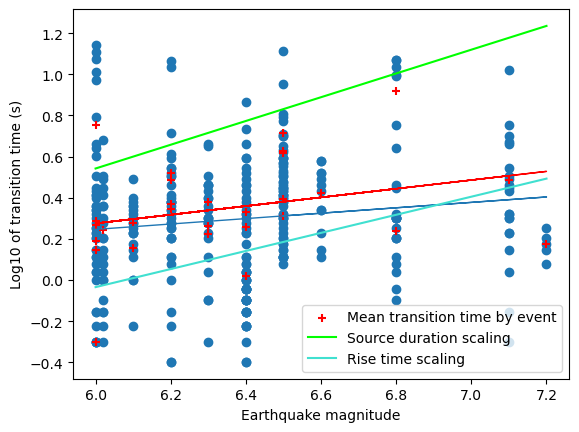

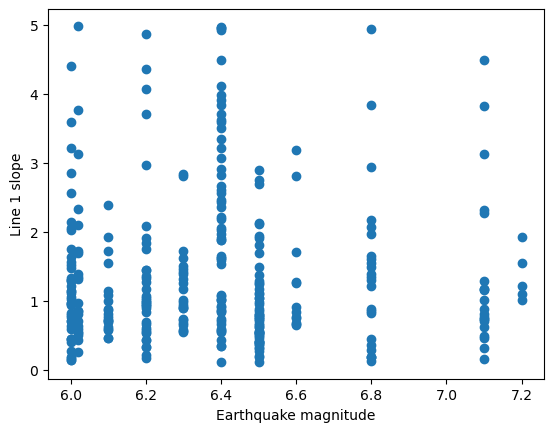

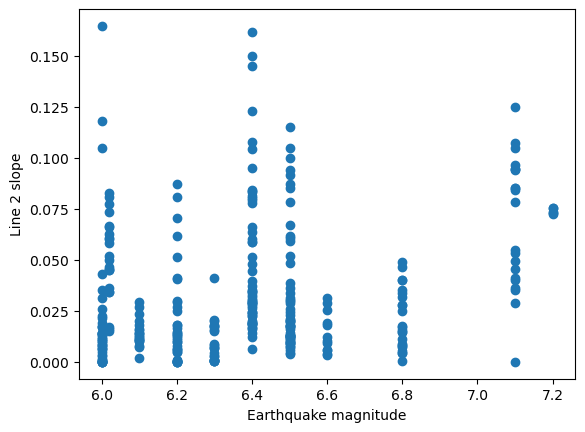

In [15]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()



plt.scatter(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10))
plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.plot(mags, mags * m + b, color = 'red', lw = 1)
plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.semilogy()
plt.legend()
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 1 slope')
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 2 slope')
plt.show()

In [16]:
# mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
#                              np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
#                              np.array(sigmas_list), np.array(trans_time_list)))

pd_mcmc = pd.DataFrame(mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path_to_files + '3comp_newdetrend_mcmc_arrays/mcmc_results_summary.csv', index = False)

In [17]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path_to_files + '3comp_newdetrend_mcmc_arrays/mcmc_results_summary.csv')
mcmc_results

eq_id  mag   sta  hypdist  xhigh        m1        m2  \
0      2023-04-13_M6  6.0  B004      398     60  0.936112  0.013814   
1      2023-04-13_M6  6.0  B005      468     60  0.714197  0.014107   
2      2023-04-13_M6  6.0  B012      299     60  1.637764  0.016722   
3      2023-04-13_M6  6.0  B927      349     60  2.142285  0.009830   
4      2023-04-13_M6  6.0  B928      330     60  1.052673  0.013210   
..               ...  ...   ...      ...    ...       ...       ...   
318  2010-01-10_M6.5  6.5  B054      377     35  0.763227  0.003518   
319  2010-01-10_M6.5  6.5  B057      344     35  0.501921  0.023050   
320  2010-01-10_M6.5  6.5  B066      499     35  0.550780  0.033867   
321  2010-01-10_M6.5  6.5  B933       89     35  2.891625  0.060752   
322  2010-01-10_M6.5  6.5  B935       96     35  2.697297  0.025911   

        xinter     sigma  trans_time  
0    11.617084  0.086102        11.7  
1    11.545278  0.065926        11.6  
2    11.008747  0.079840        11.1  
3    10.988762  0.081999        11.0  
4    11.505549  0.062946        11.6  
..         ...       ...         ...  
318  12.726111  0.053391        12.8  
319  13.805371  0.095658        13.9  
320  12.828244  0.119180        12.9  
321  11.245707  0.223984        11.3  
322  11.485070  0.191228        11.5  

[323 rows x 10 columns]

In [18]:
print(np.mean(mcmc_results['m1'].values))
print(np.mean(mcmc_results['m2'].values))
print(np.mean(mcmc_results['xinter'].values))

print(np.median(mcmc_results['m1'].values))
print(np.median(mcmc_results['m2'].values))
print(np.median(mcmc_results['xinter'].values))

1.3853392636237625
0.031892105059827716
12.532301779843605
1.0095840286427966
0.0190787360040548
11.952499929853133
